- Welcome to Quantitative and High Frequency Trading Training Program
- In this week, we will


- Add rolling maximum and minimum to the data
- Test 5 predictive signals and generate each result
- Compare the resutls to see which signal perform the best
- Compare each day's result to check which days perform the best or worst
- Make some adjustments to the signals and check out the result
- Repeat the process to another data set I give you, each person may have different data sets


- We can repeat some of the process of week 2


- Change the path of helper.r if needed

In [54]:
from stock_helper import *
from stock_stats import *
from imp import reload  
import stock_helper
import stock_stats
reload(stock_helper)
reload(stock_stats)
## if there is any conflict of duplicate functions between helper and stats
## we use the function of stats

<module 'stock_stats' from '/Users/junsu/Dropbox/workspace/stock_week5/src/w3/src/stock_stats.py'>

# Parameters

In [55]:
period = 4096
period_list = [4096]

# Path

In [56]:
HEAD_PATH = './'
DATA_PATH = HEAD_PATH + "data/stocks/"
SAVE_PATH = HEAD_PATH + "ckpt/"
TEMP_PATH = SAVE_PATH + "tmp pkl/"
OUTPUT_PATH = HEAD_PATH + 'output/'

In [57]:
import warnings
 
warnings.filterwarnings('ignore')

 number of cores, set this number according to your computer

In [58]:
#CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM =  11

- sample product, you can change to your specific product symbol

In [59]:
product_list = ["600519", "000858", "000568", "600809", "002304"]
product = product_list[0]

- get all of the dates

In [60]:
import dask
from dask import compute, delayed

- get good night date

- now it's see why we use this kind of data

# Functions Overwirtes

原notebook function overwrite散落在各个地方，汇总在这里。原位置的函数，注释掉，但不delete。万一有问题，方便恢复。

## Load Factor

In [61]:
def get_all_signal(file_list, product, signal_name, period, HEAD_PATH="d:/intern", SIGNAL_PATH="d:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S = load(SIGNAL_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        signal = S
        #moving_average(signal,period)
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    return all_signal

## Grid Search + Backtesting All grid paths- Standalone Single Stock

In [62]:
from collections import OrderedDict
def get_signal_pnl(file, product, signal_name, thre_mat, reverse=1,  buy_tranct=1.5e-4, sell_tranct=11.5e-4,
                   max_spread=0.011,
                   HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH, atr_filter=0):
    ## load data
    data = load(DATA_PATH+product+"/"+file)
    S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
    pred = S*reverse
    atr = load(SAVE_PATH+"/tmp pkl/"+product+"/"+"atr.4096"+"/"+file)
    #n_bar = len(data)
    
    ## load signal
    
    ## we don't know the signal is positive correlated or negative correlated  
    #n_thre = len(thre_mat)
    date = np.array([x[0:10] for x in data["date.time"]])
    next_date = np.append(date[1:],'1')
    end_day = date!=next_date
    count = 0;
    n_day = sum(end_day)
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((n_day, n_thre))
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)

    cur_spread = data["ask1"]-data["bid1"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        #change_pos = position - position.shift(1)
        #notional_change_pos = notional_position-notional_position.shift(1)
        change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        #notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        change_base[change_buy] = data["next.ask"][change_buy]*(1+buy_tranct)*data["adjust"]
        change_base[change_sell] = data["next.bid"][change_sell]*(1-sell_tranct)*data["adjust"]
        raw_pnl = -(change_base*change_pos).cumsum()+notional_position*data["wpr"]
        final_pnl = -sum(change_base*change_pos) ## total pnl, there is a negative sign, because selling get money and buying pay money
        turnover = sum(change_base*abs(change_pos))
        num = sum((position!=0) & (change_pos!=0)) ## number of trades
        hld_period = sum(position!=0)   ## holding period
        daily_pnl = raw_pnl[end_day].reset_index(drop=True)
        pnl = np.append(daily_pnl[0], np.diff(daily_pnl))
        all_pnl[:,thre[0]] = pnl
        if (num==0):
            result.loc[thre[0], ("num","avg.ret","ret")] = (0,0,0)
        else:
            result.loc[thre[0],("num", "avg.ret", "ret", )] = (num, final_pnl/num, final_pnl)
    return OrderedDict([("all.pnl", all_pnl), ("result", result), ("date", date[end_day])])

## Calculate Stats over GS, BS results - Standalone Single Stock

In [63]:
from collections import OrderedDict
def get_hft_summary(result, thre_mat):
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((0,n_thre))
    all_dates = np.array([])
    for i in range(len(result)):
        all_pnl =  np.concatenate((all_pnl,result[i]["all.pnl"]),axis=0)
        all_dates = np.append(all_dates, result[i]["date"])
    stat = result[0]["result"].iloc[:,2:]
    for i in range(1,len(result)):
        stat = stat+result[i]["result"].iloc[:,2:]
    stat["avg.ret"]=stat["ret"]/stat["num"]
    
    total_ret = all_pnl.sum(0)
    total_sharpe = np.zeros(n_thre)
    total_drawdown = np.zeros(n_thre)
    total_max_drawdown = np.zeros(n_thre)
    for i in range(n_thre):
        total_sharpe[i] = sharpe(all_pnl[:,i])
        total_drawdown[i] = drawdown(all_pnl[:,i])
        total_max_drawdown[i] = max_drawdown(all_pnl[:,i])
    final_result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"]), ("close", thre_mat["close"]), ("num", stat["num"]),
                                                  ("avg.ret", stat["avg.ret"]), ("total.ret",total_ret), ("sharpe", total_sharpe),
                                                  ("drawdown", total_drawdown), ("max.drawdown", total_max_drawdown),
                                                 ("mar", total_ret/total_max_drawdown)]), 
                                index=thre_mat.index)
    return OrderedDict([("final.result", final_result), ("daily.pnl", all_pnl), ("date", all_dates)])

## Grid Search + Backtesting All grid paths - Train+Test - All Stocks

In [96]:
## get backtest result of a signal on a product's list
from collections import OrderedDict
def get_list_signal_stat(signal_name, thre_mat_list, product_list, atr_filter_list,
                    split_str="2018", min_pnl=2, min_num=20, reverse=1):
    CORE_NUM = 11#int(os.environ['NUMBER_OF_PROCESSORS'])
    train_trade_stat = dict([]) ## training result statistics
    print("training")
    for product in product_list:
        print(product)
        all_dates = np.array(list(map(lambda x: x, sorted(os.listdir(DATA_PATH + product)))))
        train_sample = np.array(all_dates)<split_str ## training samples
        test_sample = np.array(all_dates)>split_str ## test samples
        print(sum(train_sample), sum(test_sample))
        thre_mat = thre_mat_list[product]
        atr_filter = atr_filter_list[product]
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1,
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=atr_filter)
            train_result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
        trade_stat = get_hft_summary(train_result, thre_mat)
        train_trade_stat[product] = trade_stat
    print("testing")
    test_trade_stat = dict([])
    for product in product_list:
        all_dates = np.array(list(map(lambda x: x,os.listdir(DATA_PATH + product))))
        print(product)
        train_sample = np.array(all_dates)<split_str ## training samples
        test_sample = np.array(all_dates)>split_str ## test samples
        thre_mat = thre_mat_list[product]
        reverse = reverse_list[product]
        atr_filter = atr_filter_list[product]
        with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
            f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1,
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=atr_filter)
            result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
        trade_stat = get_hft_summary(result, thre_mat)
        test_trade_stat[product] = trade_stat
    result=dict([])
    result["train_trade_stat"] = train_trade_stat ## save train stat
    result["test_trade_stat"] = test_trade_stat ## save test stat
    if reverse==-1:
        save(result, OUTPUT_PATH+"/"+signal_name+".result.pkl") ## reversal strategy
    else:
        save(result, OUTPUT_PATH+"/"+signal_name+".pos.result.pkl") ## trend strategy

## Choose good strategies based on train & test result

In [65]:
## get train and test result, choose good strategies, plot the portfolio and result of each product

def get_list_signal_result(signal_name, product_list, split_str="2018", reverse=1,
                           min_pnl=2, min_num=20, atr_filter=20):
    if reverse==-1:
        result = load(OUTPUT_PATH+"/"+signal_name+".result.pkl") ## load reversal strat statistics
    else:
        result = load(OUTPUT_PATH+"/"+signal_name+".pos.result.pkl") ## load trend strat statistics
    train_trade_stat = result["train_trade_stat"]
    test_trade_stat = result["test_trade_stat"]
    train_sample = np.array(all_dates)<split_str
    test_sample = np.array(all_dates)>split_str
    i = 0
    for product in product_list:
        trade_stat = train_trade_stat[product]
        ## two criterion: minimum averge pnl (unit is spread), monimum number of trades
        good_strat = (trade_stat["final.result"]["avg.ret"]>min_pnl) & (trade_stat["final.result"]["num"]>min_num)
        if sum(good_strat)>0:
            train_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
            trade_stat = test_trade_stat[product]
            test_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
            print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
            i = i+1

# Loading

In [66]:
all_dates = sorted(os.listdir(DATA_PATH + product_list[0]))
all_dates.sort()
n_days = len(all_dates)


- we randomly choose a day

In [67]:
data = load(DATA_PATH+product_list[0]+"/"+all_dates[1])

In [68]:
data.columns

Index(['date.time', 'price', 'traded.num', 'turnover', 'qty', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'ask1', 'ask2', 'ask3', 'ask4', 'ask5',
       'bid1.qty', 'bid2.qty', 'bid3.qty', 'bid4.qty', 'bid5.qty', 'ask1.qty',
       'ask2.qty', 'ask3.qty', 'ask4.qty', 'ask5.qty', 'adjust', 'wpr',
       'next.bid', 'next.ask', 'wpr.ret', 'ret', 'min.4096', 'max.4096'],
      dtype='object')

# Profiling

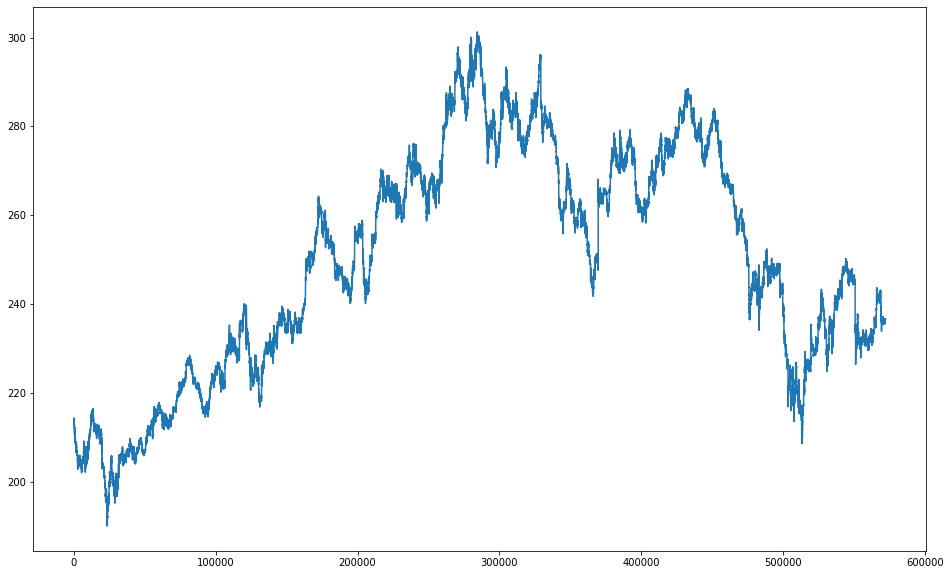

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values);

- plot the maximum price of 2048 ticks
- plot the minimum price of 2048 ticks

In [70]:
#period_list = [4096]

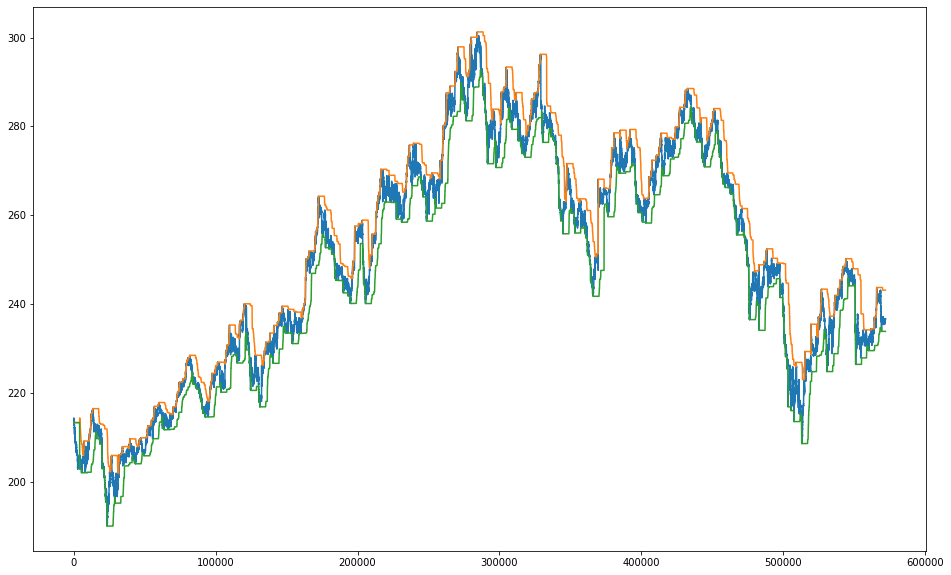

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values)
plt.plot(data["max.4096"].values)
plt.plot(data["min.4096"].values);

## we can see the result meets our expectation
## it may take long time to calculate the min and max of wpr prices
## I give you the estimated time of using 4 cores, so you can deal with other affairs while waiting for result
## but signals using min/max would be sometimes very useful
## the the time to calculating min/max pay off in the end
## In practice, when using c++ to calculating min/max on a rolling basis
## there would be some efficient algorithm, which is faster than comparing all numbers at every tick
## we would talk about it later in our C++ class

- Test 5 predictive signals and generate each result
- now let's see the first signal, which is simply related to price action without trading volume


- set the sample period length

In [21]:
#period = 4096

# Factor dbook

## Define Factor

- the first signal

In [72]:
## utilize the bid and ask quantity changes
## but the original quantity may not be stationary, i.e. it would have very large values
## usually from 0 to 200
## but can be up to several tens of thousand
## so we use the change of qty's direction instead
## it has only -1 0 1 so it's stionary, but it's dicrerte
## then we add ewma as fitler to make it more continuous
## we hope the signals are continuous values

from collections import OrderedDict
class foctor_dbook_period(factor_template):
    factor_name = "dbook.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        bid_qty = data["bid1.qty"]+data["bid2.qty"]+data["bid3.qty"]+data["bid4.qty"]+data["bid5.qty"]
        diff_bid_qty = bid_qty - bid_qty.shift()
        diff_bid_qty[0] = 0
        ask_qty = data["ask1.qty"]+data["ask2.qty"]+data["ask3.qty"]+data["ask4.qty"]+data["ask5.qty"]
        diff_ask_qty = ask_qty - ask_qty.shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values

In [73]:
x3 = foctor_dbook_period()
x3


factor_name:
dbook.period

formula:
    def formula(self, data, period):
        bid_qty = data["bid1.qty"]+data["bid2.qty"]+data["bid3.qty"]+data["bid4.qty"]+data["bid5.qty"]
        diff_bid_qty = bid_qty - bid_qty.shift()
        diff_bid_qty[0] = 0
        ask_qty = data["ask1.qty"]+data["ask2.qty"]+data["ask3.qty"]+data["ask4.qty"]+data["ask5.qty"]
        diff_ask_qty = ask_qty - ask_qty.shift()
        diff_ask_qty[0] = 0
        return ewma(np.sign(diff_bid_qty)-np.sign(diff_ask_qty), period, adjust=True).values


params:
$period:[4096]

- create directory for dbook signal

## Factor Generation

In [74]:
#SAVE_PATH = "e:/intern"
for product in product_list:
    create_signal_path(x3, product, SAVE_PATH)

./ckpt//tmp pkl/600519/dbook.4096
./ckpt//tmp pkl/000858/dbook.4096
./ckpt//tmp pkl/000568/dbook.4096
./ckpt//tmp pkl/600809/dbook.4096
./ckpt//tmp pkl/002304/dbook.4096


In [75]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, sorted(os.listdir(DATA_PATH + product))))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x3, product=product, HEAD_PATH=SAVE_PATH,n=8)
;

# Wall time: 1min 36s
# ''

CPU times: user 305 ms, sys: 339 ms, total: 644 ms
Wall time: 34.8 s


''

In [76]:
def moving_average(a, n=3) :
    ret_sum = np.cumsum(a, dtype=float)
    ret = a
    ret[n:] = (ret_sum[n:] - ret_sum[:-n])/n
    return ret

- now we write the all.signal part into a function

## Load dbook Factor Signals

In [77]:
'''
def get_all_signal(file_list, product, signal_name, period, HEAD_PATH="d:/intern", SIGNAL_PATH="d:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S = load(SIGNAL_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        signal = S
        #moving_average(signal,period)
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    return all_signal
'''    

'\ndef get_all_signal(file_list, product, signal_name, period, HEAD_PATH="d:/intern", SIGNAL_PATH="d:/intern"):\n    n_files = len(file_list)\n    all_signal = np.array([])\n    for file in file_list:\n        S = load(SIGNAL_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)\n        signal = S\n        #moving_average(signal,period)\n        chosen = (np.arange(len(signal))+1) % period==0\n        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)\n    return all_signal\n'

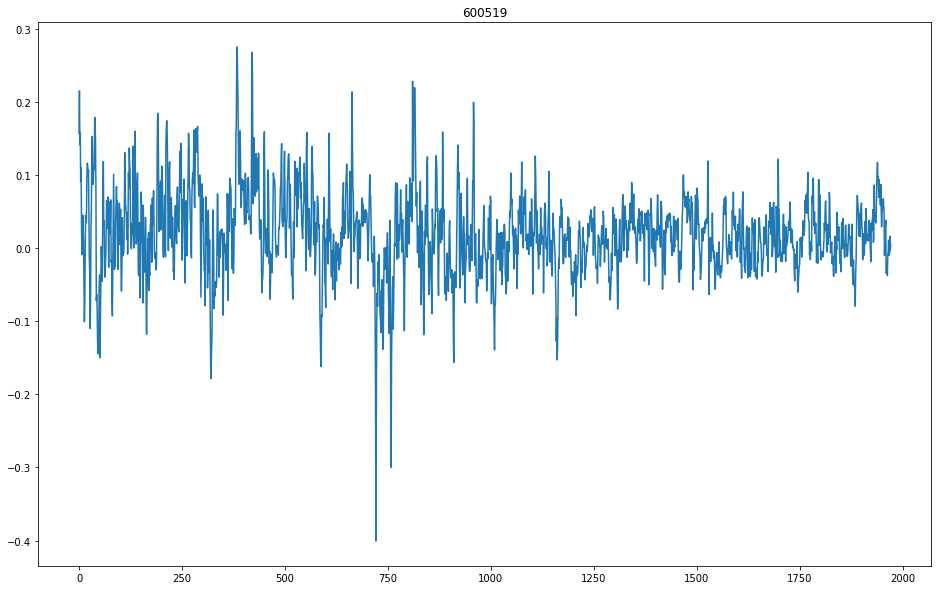

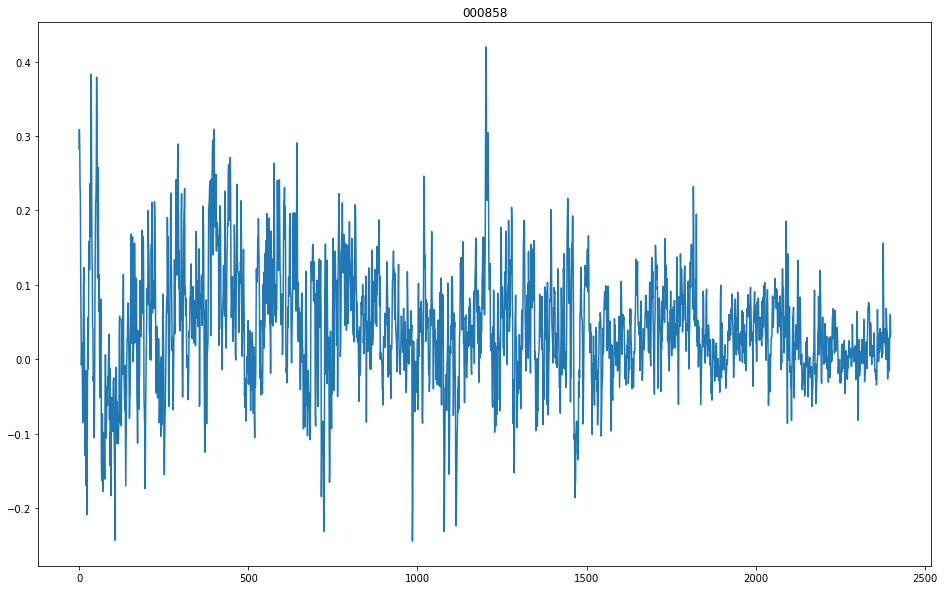

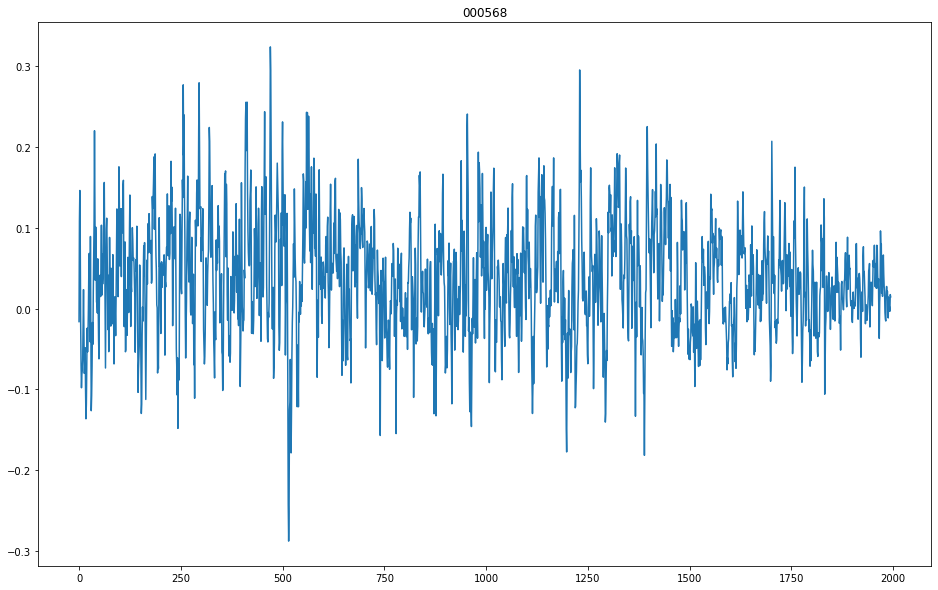

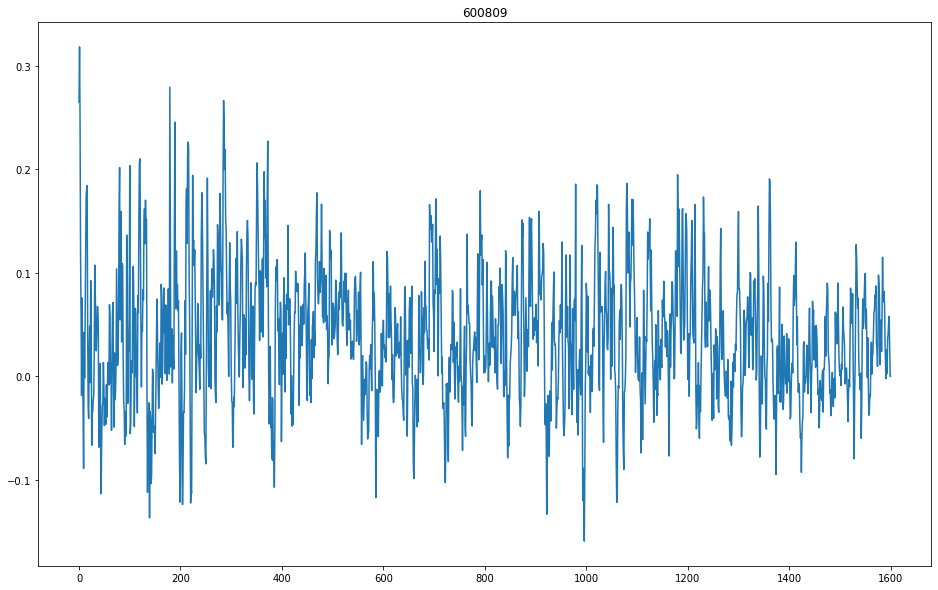

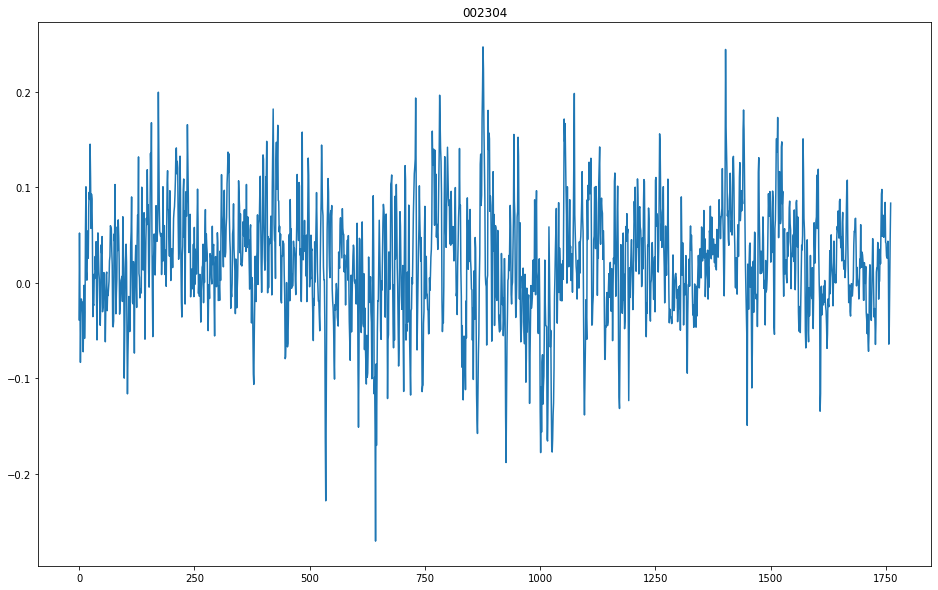

In [78]:
i = 0
for product in product_list:
    all_dates = sorted(os.listdir(DATA_PATH + product))
    all_signal = get_all_signal(np.array(all_dates), product, "dbook."+str(period), period, HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

In [79]:
print(len(all_signal))
## 745

1761


## Load atr Factor Signals

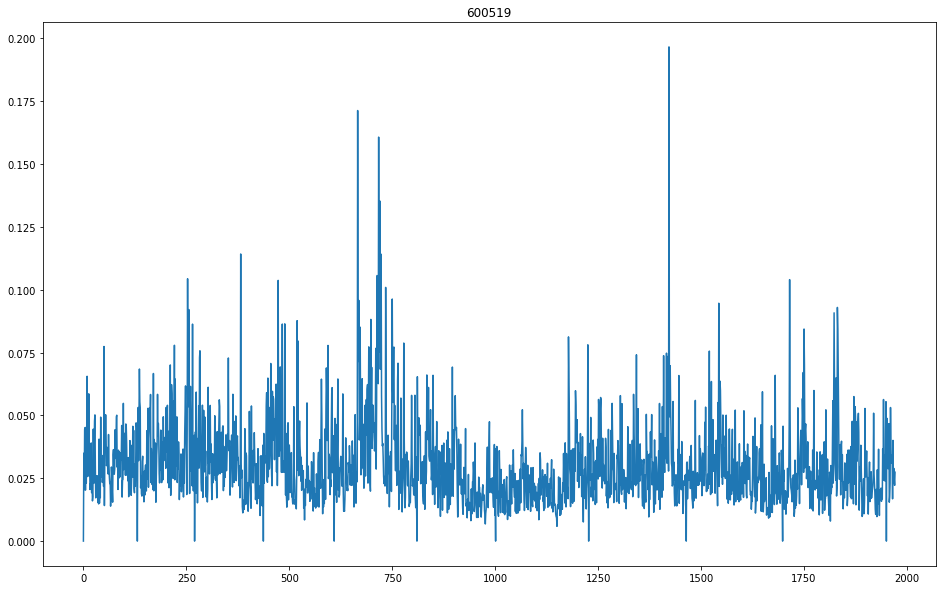

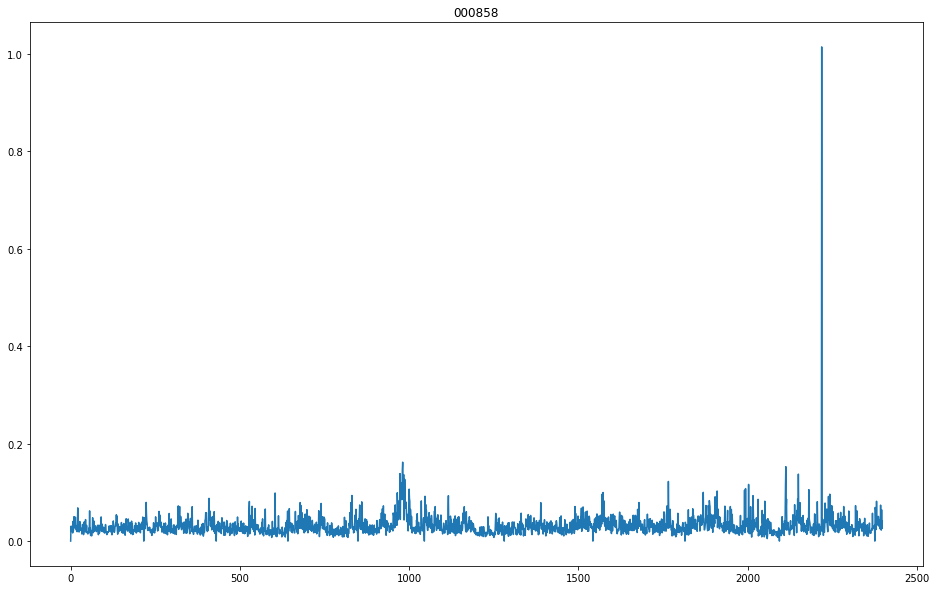

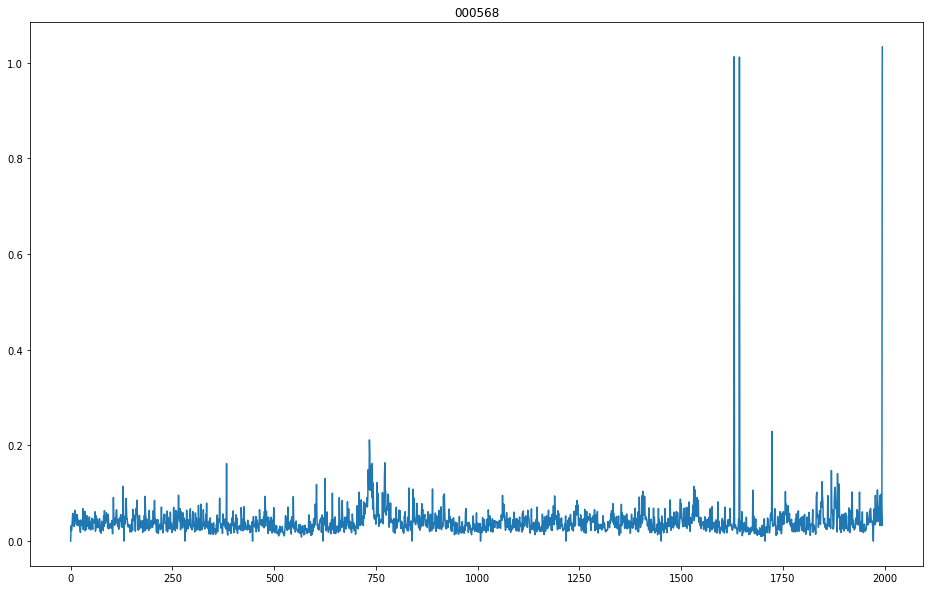

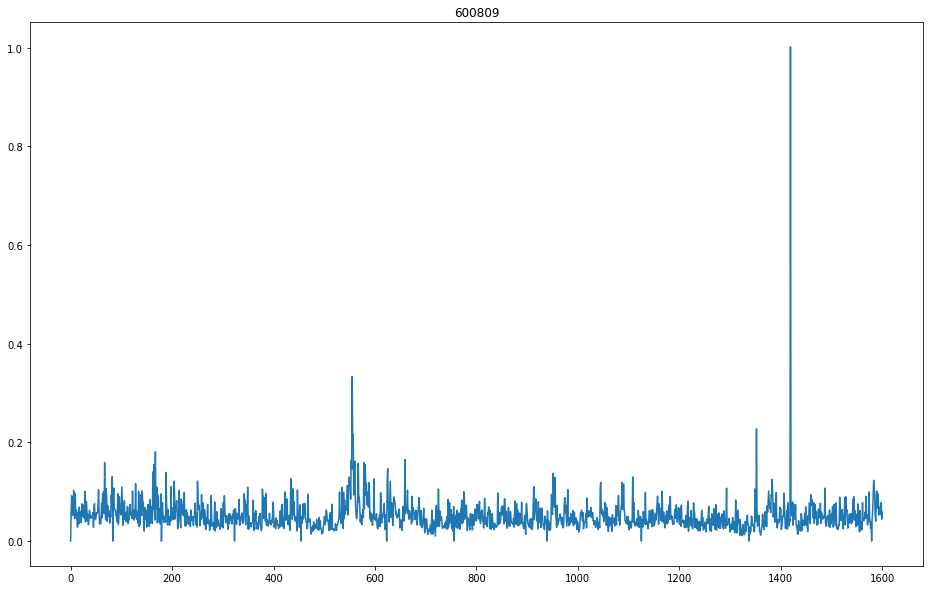

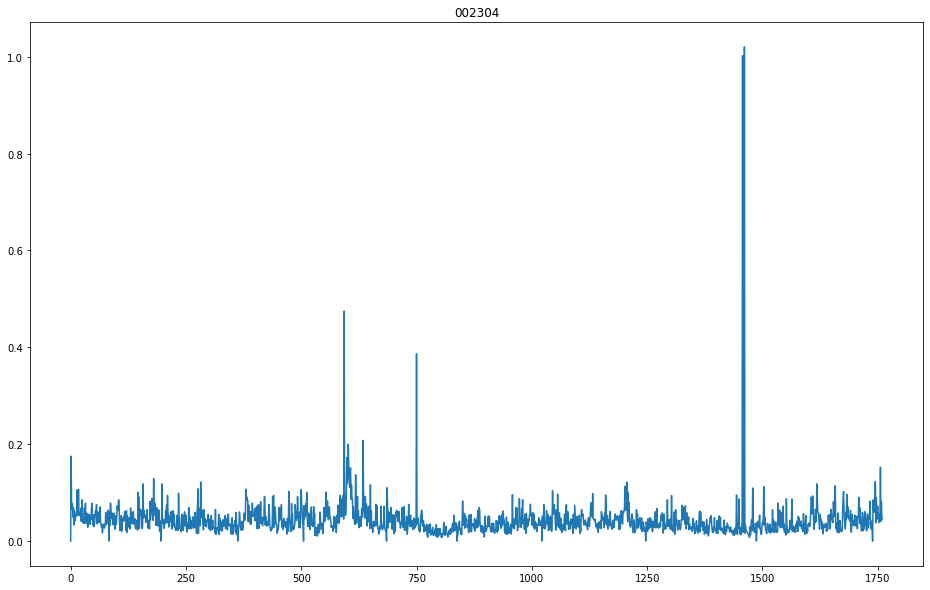

In [80]:
i = 0
for product in product_list:
    all_dates = sorted(os.listdir(DATA_PATH + product))
    all_signal = get_all_signal(np.array(all_dates), product, "atr."+str(period), period, HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

- there is no extreme values

## Strategy based on dbook & atr

In [97]:
'''
from collections import OrderedDict
def get_signal_pnl(file, product, signal_name, thre_mat, reverse=1,  buy_tranct=1.5e-4, sell_tranct=11.5e-4,
                   max_spread=0.011,
                   HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH, atr_filter=0):
    ## load data
    data = load(DATA_PATH+product+"/"+file)
    S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
    pred = S*reverse
    atr = load(SAVE_PATH+"/tmp pkl/"+product+"/"+"atr.4096"+"/"+file)
    #n_bar = len(data)
    
    ## load signal
    
    ## we don't know the signal is positive correlated or negative correlated  
    #n_thre = len(thre_mat)
    date = np.array([x[0:10] for x in data["date.time"]])
    next_date = np.append(date[1:],'1')
    end_day = date!=next_date
    count = 0;
    n_day = sum(end_day)
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((n_day, n_thre))
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)

    cur_spread = data["ask1"]-data["bid1"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        #change_pos = position - position.shift(1)
        #notional_change_pos = notional_position-notional_position.shift(1)
        change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        #notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        change_base[change_buy] = data["next.ask"][change_buy]*(1+buy_tranct)*data["adjust"]
        change_base[change_sell] = data["next.bid"][change_sell]*(1-sell_tranct)*data["adjust"]
        raw_pnl = -(change_base*change_pos).cumsum()+notional_position*data["wpr"]
        final_pnl = -sum(change_base*change_pos) ## total pnl, there is a negative sign, because selling get money and buying pay money
        turnover = sum(change_base*abs(change_pos))
        num = sum((position!=0) & (change_pos!=0)) ## number of trades
        hld_period = sum(position!=0)   ## holding period
        daily_pnl = raw_pnl[end_day].reset_index(drop=True)
        pnl = np.append(daily_pnl[0], np.diff(daily_pnl))
        all_pnl[:,thre[0]] = pnl
        if (num==0):
            result.loc[thre[0], ("num","avg.ret","ret")] = (0,0,0)
        else:
            result.loc[thre[0],("num", "avg.ret", "ret", )] = (num, final_pnl/num, final_pnl)
    return OrderedDict([("all.pnl", all_pnl), ("result", result), ("date", date[end_day])])
'''    

'\nfrom collections import OrderedDict\ndef get_signal_pnl(file, product, signal_name, thre_mat, reverse=1,  buy_tranct=1.5e-4, sell_tranct=11.5e-4,\n                   max_spread=0.011,\n                   HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH, atr_filter=0):\n    ## load data\n    data = load(DATA_PATH+product+"/"+file)\n    S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)\n    pred = S*reverse\n    atr = load(SAVE_PATH+"/tmp pkl/"+product+"/"+"atr.4096"+"/"+file)\n    #n_bar = len(data)\n    \n    ## load signal\n    \n    ## we don\'t know the signal is positive correlated or negative correlated  \n    #n_thre = len(thre_mat)\n    date = np.array([x[0:10] for x in data["date.time"]])\n    next_date = np.append(date[1:],\'1\')\n    end_day = date!=next_date\n    count = 0;\n    n_day = sum(end_day)\n    n_thre = np.shape(thre_mat)[0]\n    all_pnl = np.zeros((n_day, n_thre))\n    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", t

## Grid Search

In [98]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.1, 0.3, 0.01)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))

- get the result of training sample

In [99]:
'''
from collections import OrderedDict
def get_hft_summary(result, thre_mat):
    n_thre = np.shape(thre_mat)[0]
    all_pnl = np.zeros((0,n_thre))
    all_dates = np.array([])
    for i in range(len(result)):
        all_pnl =  np.concatenate((all_pnl,result[i]["all.pnl"]),axis=0)
        all_dates = np.append(all_dates, result[i]["date"])
    stat = result[0]["result"].iloc[:,2:]
    for i in range(1,len(result)):
        stat = stat+result[i]["result"].iloc[:,2:]
    stat["avg.ret"]=stat["ret"]/stat["num"]
    
    total_ret = all_pnl.sum(0)
    total_sharpe = np.zeros(n_thre)
    total_drawdown = np.zeros(n_thre)
    total_max_drawdown = np.zeros(n_thre)
    for i in range(n_thre):
        total_sharpe[i] = sharpe(all_pnl[:,i])
        total_drawdown[i] = drawdown(all_pnl[:,i])
        total_max_drawdown[i] = max_drawdown(all_pnl[:,i])
    final_result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"]), ("close", thre_mat["close"]), ("num", stat["num"]),
                                                  ("avg.ret", stat["avg.ret"]), ("total.ret",total_ret), ("sharpe", total_sharpe),
                                                  ("drawdown", total_drawdown), ("max.drawdown", total_max_drawdown),
                                                 ("mar", total_ret/total_max_drawdown)]), 
                                index=thre_mat.index)
    return OrderedDict([("final.result", final_result), ("daily.pnl", all_pnl), ("date", all_dates)])
'''

'\nfrom collections import OrderedDict\ndef get_hft_summary(result, thre_mat):\n    n_thre = np.shape(thre_mat)[0]\n    all_pnl = np.zeros((0,n_thre))\n    all_dates = np.array([])\n    for i in range(len(result)):\n        all_pnl =  np.concatenate((all_pnl,result[i]["all.pnl"]),axis=0)\n        all_dates = np.append(all_dates, result[i]["date"])\n    stat = result[0]["result"].iloc[:,2:]\n    for i in range(1,len(result)):\n        stat = stat+result[i]["result"].iloc[:,2:]\n    stat["avg.ret"]=stat["ret"]/stat["num"]\n    \n    total_ret = all_pnl.sum(0)\n    total_sharpe = np.zeros(n_thre)\n    total_drawdown = np.zeros(n_thre)\n    total_max_drawdown = np.zeros(n_thre)\n    for i in range(n_thre):\n        total_sharpe[i] = sharpe(all_pnl[:,i])\n        total_drawdown[i] = drawdown(all_pnl[:,i])\n        total_max_drawdown[i] = max_drawdown(all_pnl[:,i])\n    final_result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"]), ("close", thre_mat["close"]), ("num", stat["num"]

In [100]:
HEAD_PATH

'./'

### All Data

In [101]:
# run from here

In [83]:
%%time
signal_name = "dbook."+str(period)
all_trade_stat = dict([])
#SAVE_PATH = "e:/intern"
for product in product_list:
    all_dates = list(map(lambda x: x, sorted(os.listdir(DATA_PATH + product))))
    n_days = len(all_dates)
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=0.02)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat)
    all_trade_stat[product] = trade_stat

## Wall time: 18min 14s


CPU times: user 412 ms, sys: 308 ms, total: 720 ms
Wall time: 7min 17s


In [84]:
## save backtest result
save(all_trade_stat, OUTPUT_PATH+"/"+"wine_trade_stat_"+signal_name+".pkl")

In [85]:
all_trade_stat = load(OUTPUT_PATH+"/"+"wine_trade_stat_"+signal_name+".pkl")

- get the statistics result of training sample

- let's see how many good signals there are

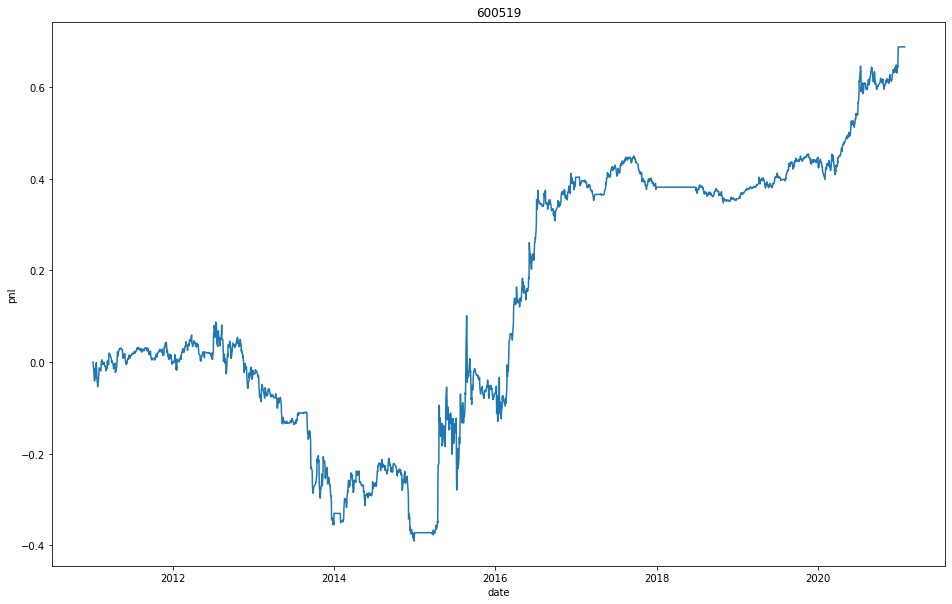

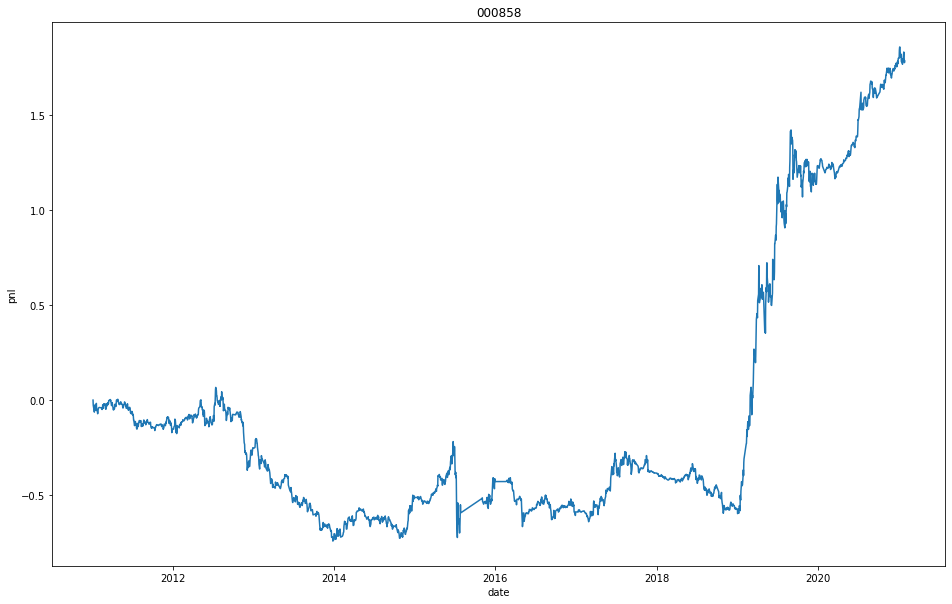

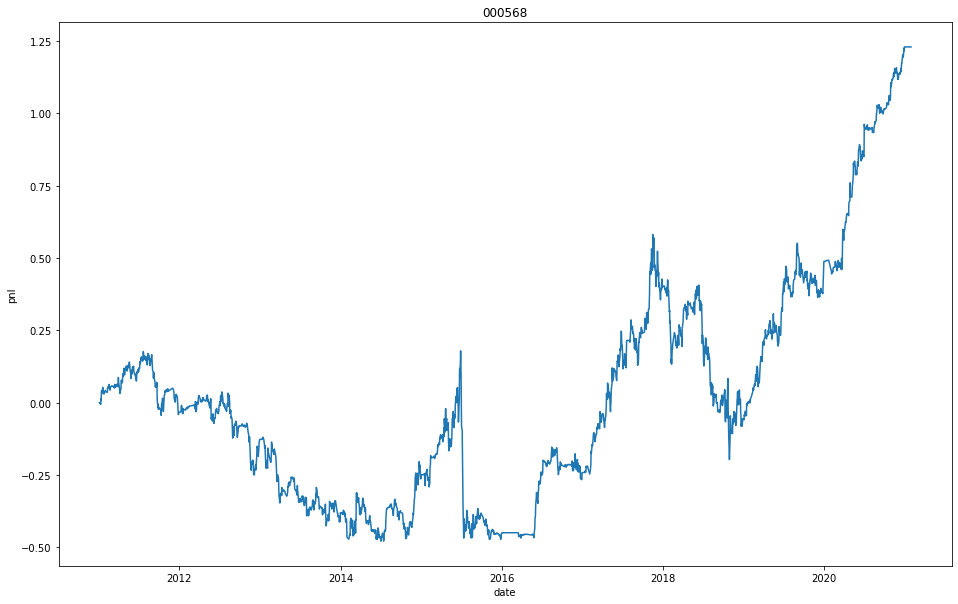

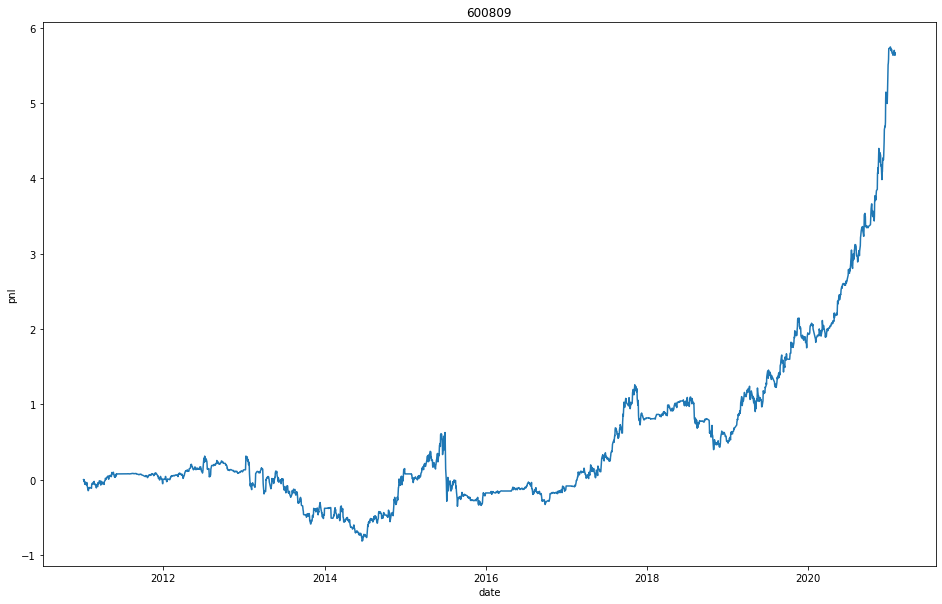

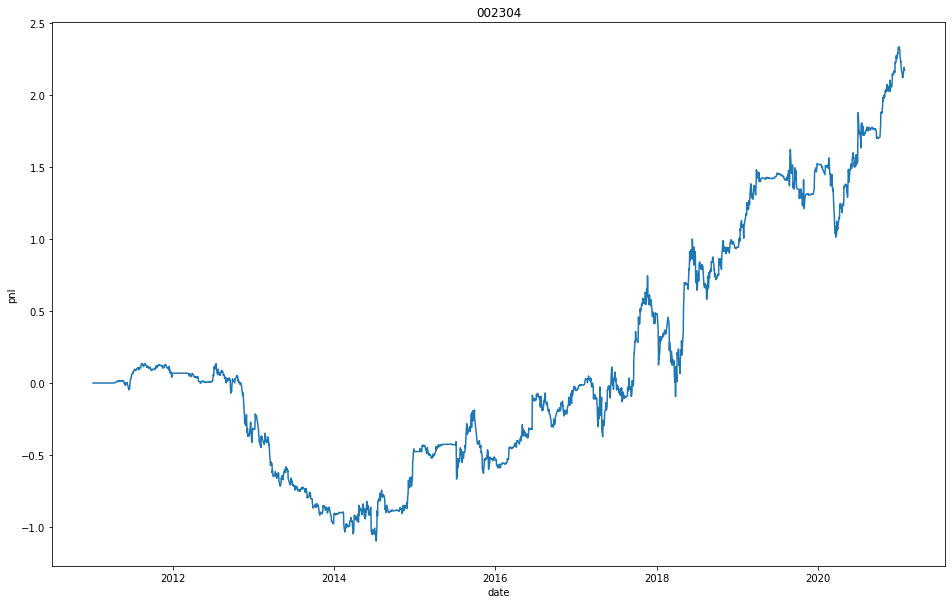

In [86]:
i = 0
for product in product_list:
    trade_stat = all_trade_stat[product]
    good_strat = trade_stat["final.result"]["avg.ret"]>0.001
    good_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    format_dates = np.array([pd.to_datetime(d) for d in trade_stat["date"]])
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates, good_pnl.cumsum());

- we can see the result is quite good
- now we can split the samples into training and testing sets

### Train Data

In [87]:
%%time
train_trade_stat = dict([])
for product in product_list:
    all_dates = np.array(list(map(lambda x: x, sorted(os.listdir(DATA_PATH + product)))))
    all_dates = all_dates[all_dates<"2017"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, 
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=0.02)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat)
    train_trade_stat[product] = trade_stat
    
## Wall time: 10min 51s

CPU times: user 283 ms, sys: 277 ms, total: 560 ms
Wall time: 4min 7s


In [88]:
save(train_trade_stat, OUTPUT_PATH+"/wine_" + signal_name+"_train_trade_stat.pkl")

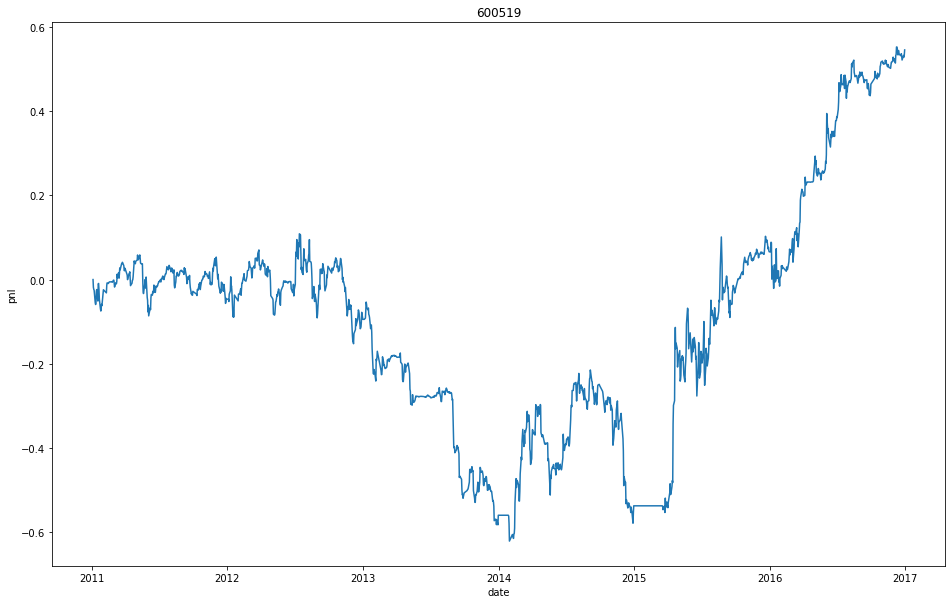

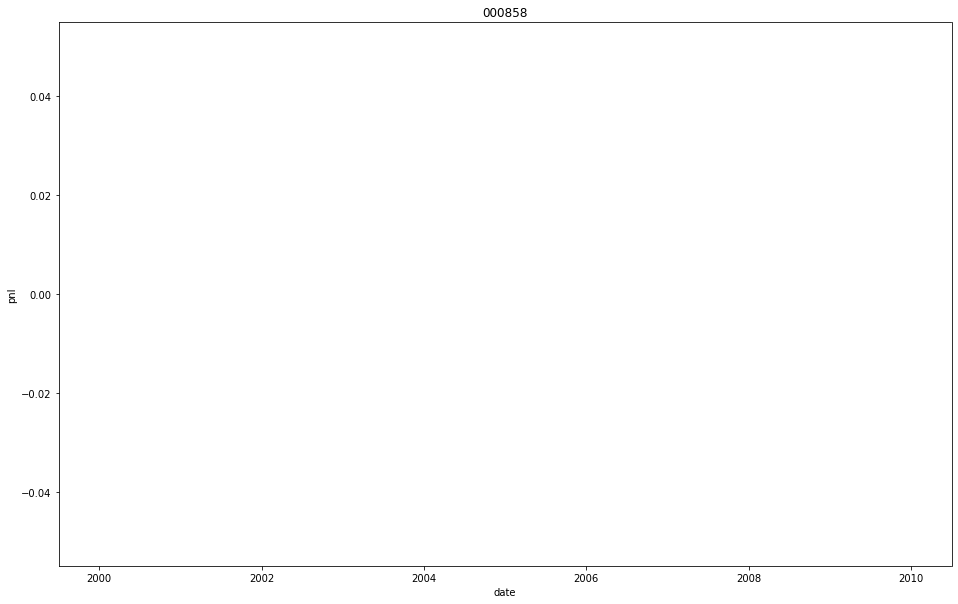

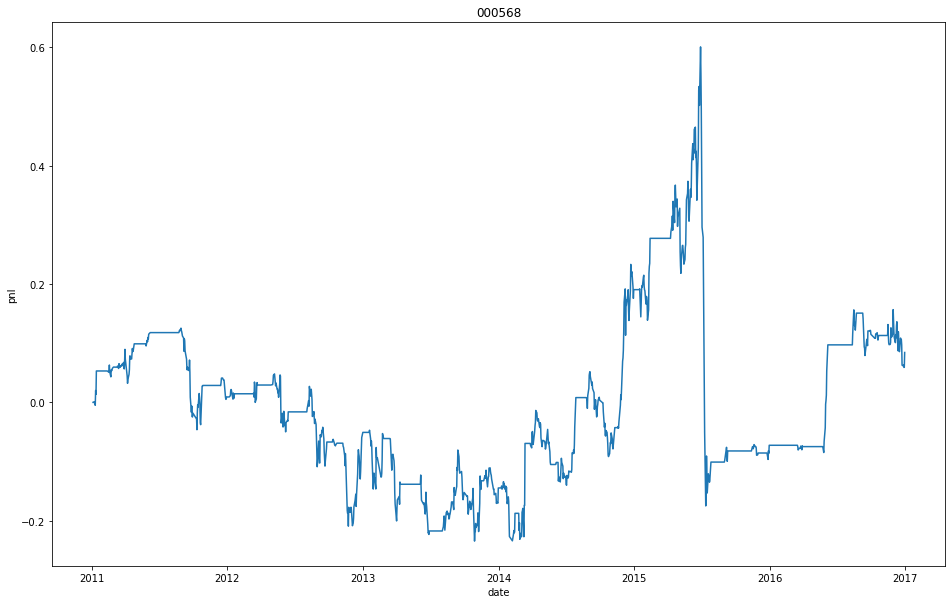

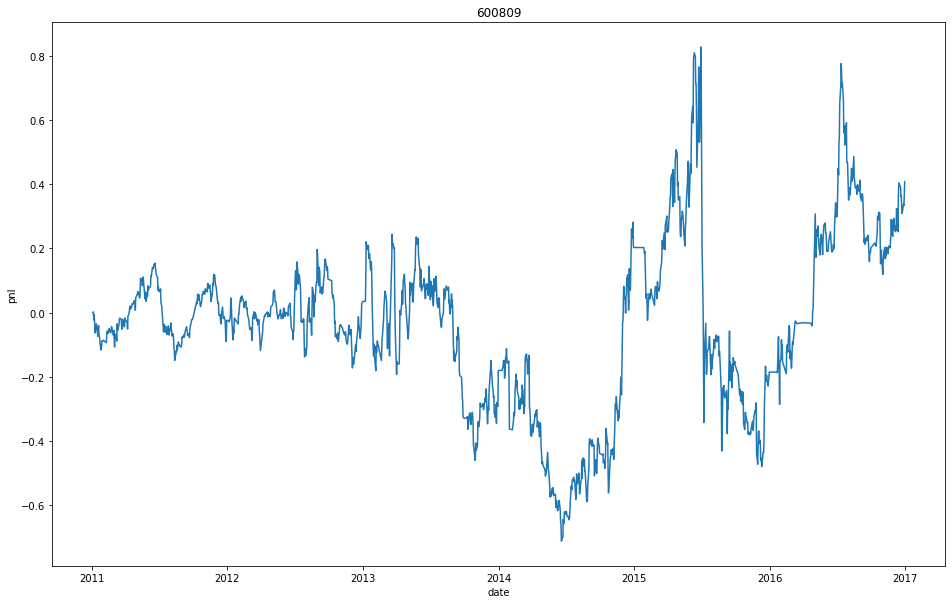

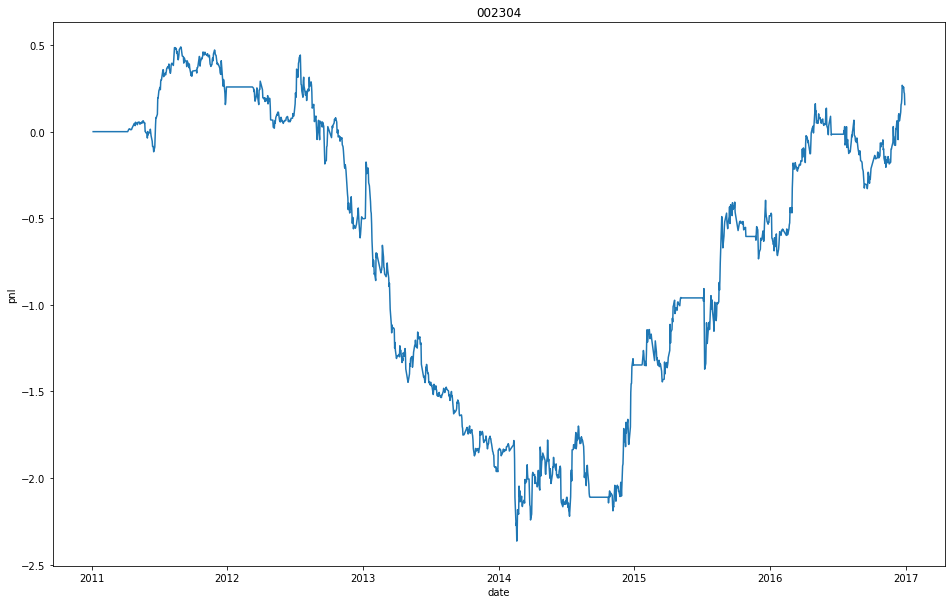

In [89]:
i = 0
train_trade_stat = load(OUTPUT_PATH+"/wine_" + signal_name +"_train_trade_stat.pkl")
for product in product_list:
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.ret"]>0.001)  & (trade_stat["final.result"]["num"]>20)
    good_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    i = i+1
    all_dates = np.array(list(map(lambda x: x, sorted(os.listdir(DATA_PATH + product)))))
    format_dates = np.array([pd.to_datetime(d) for d in trade_stat["date"]])
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates, good_pnl.cumsum());

### Test Data

In [121]:
%%time
test_trade_stat = dict([])
for product in product_list:
    print(product)
    all_dates = np.array(list(map(lambda x: x, sorted(os.listdir(DATA_PATH + product)))))
    all_dates = all_dates[all_dates>="2017"]
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1,
                                HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=0.02)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat)
    test_trade_stat[product] = trade_stat
    
## Wall time:  10min 49s

600519
000858
000568
600809
002304
CPU times: user 274 ms, sys: 315 ms, total: 589 ms
Wall time: 5min 8s


In [122]:
save(test_trade_stat, OUTPUT_PATH+"/wine_" + signal_name+"_test_trade_stat.pkl")

600519 train sharpe  0.37214017536971844 test sharpe  0.9591884028600077
000858 train sharpe  nan test sharpe  nan
000568 train sharpe  0.14279779704850123 test sharpe  -0.1073818053501664
600809 train sharpe  0.17656487410689817 test sharpe  0.2724165908826381
002304 train sharpe  0.2395797736967873 test sharpe  -0.08058735306396107


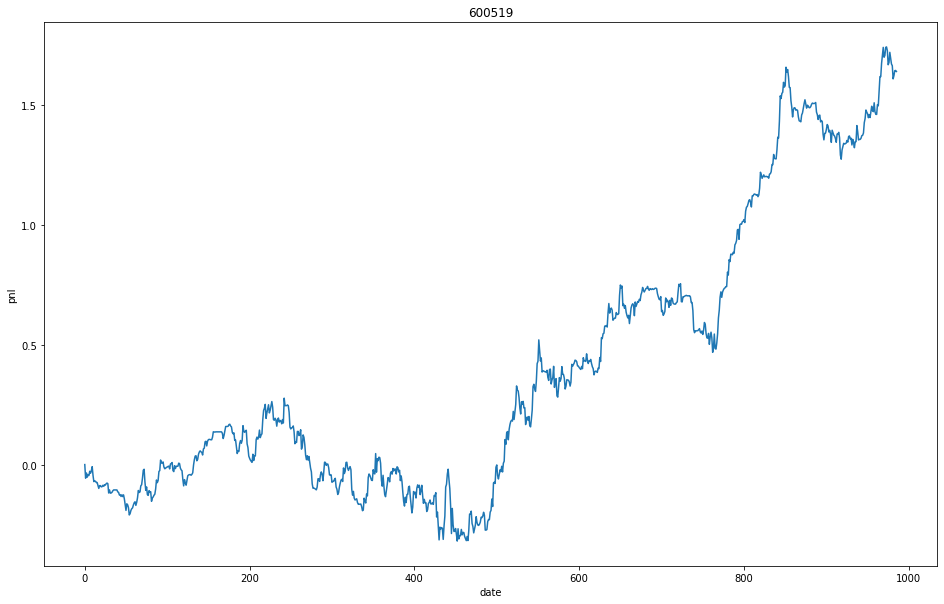

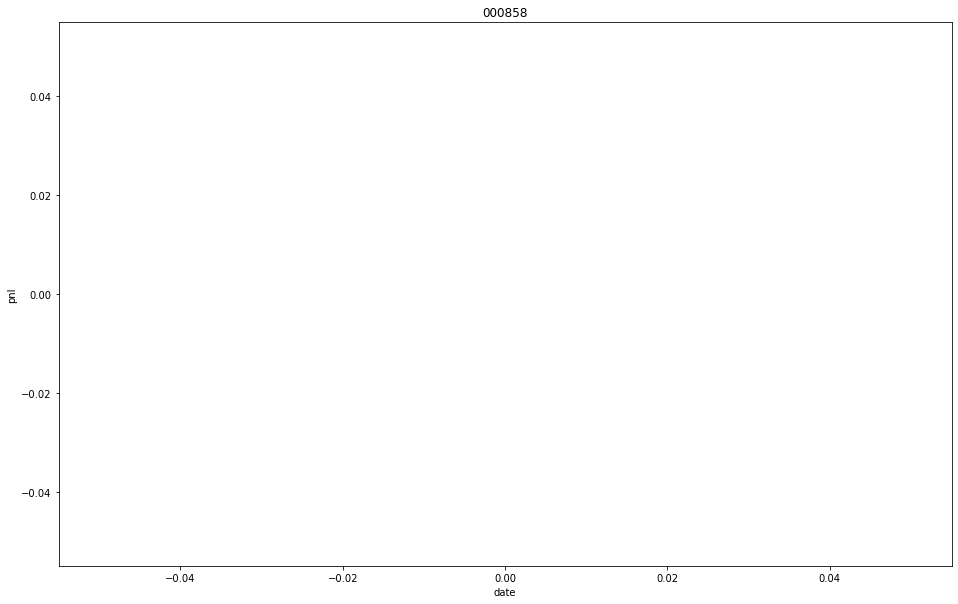

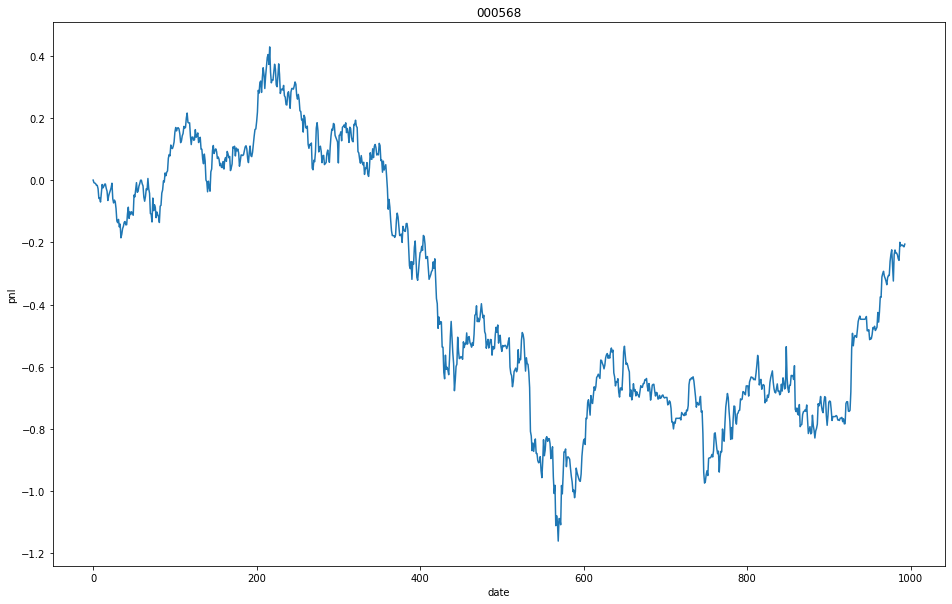

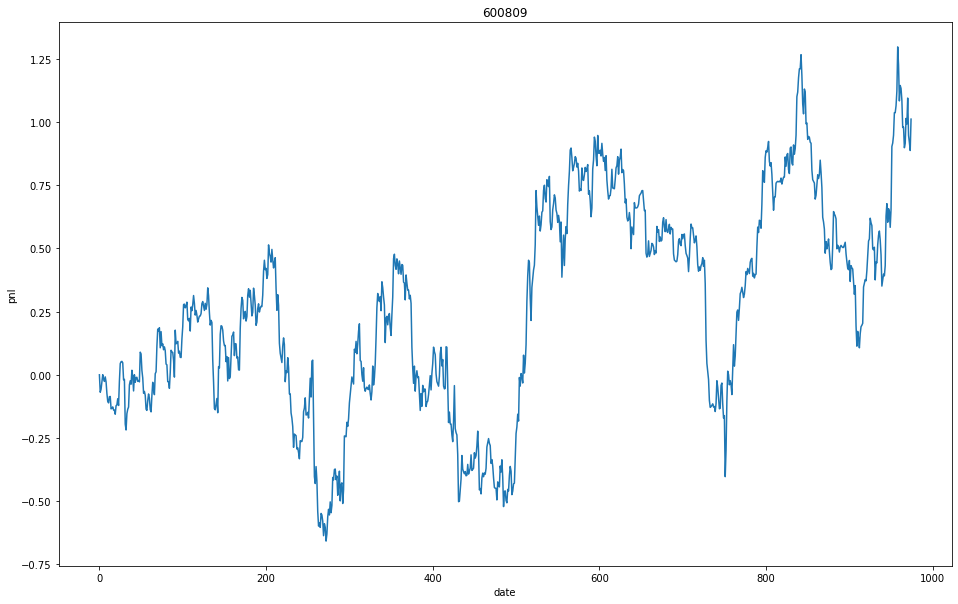

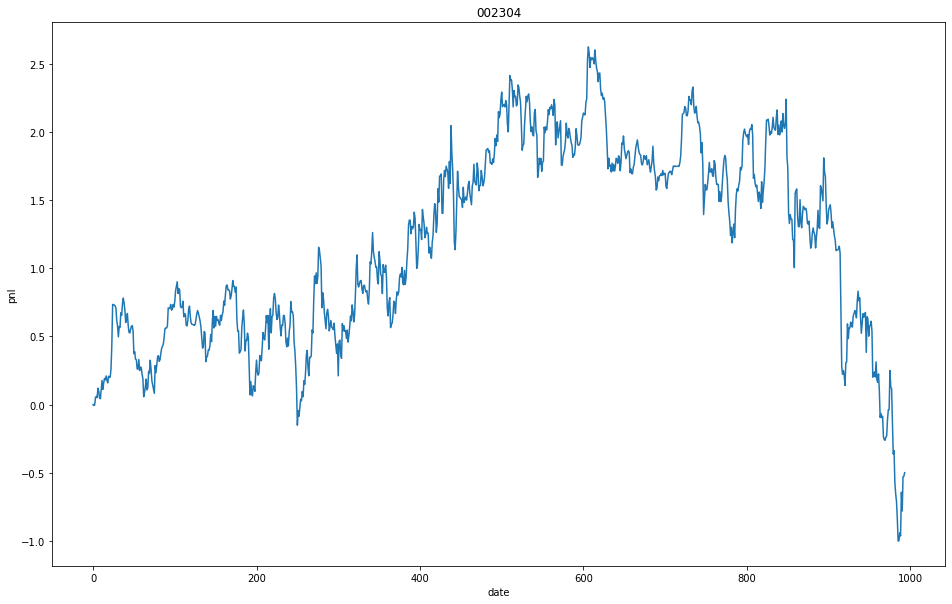

In [123]:
test_trade_stat = load(OUTPUT_PATH+"/wine_" + signal_name +"_test_trade_stat.pkl")
train_trade_stat = load(OUTPUT_PATH+"/wine_" + signal_name +"_train_trade_stat.pkl")
i = 0
for product in product_list:
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.ret"]>0.001)
    train_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    trade_stat = test_trade_stat[product]
    test_pnl = trade_stat["daily.pnl"][:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(test_pnl.cumsum());
    
# 600519 train sharpe  0.37214017536971844 test sharpe  0.9734597415785605
# 000858 train sharpe  nan test sharpe  nan
# 000568 train sharpe  0.14279779704850123 test sharpe  0.08383559361352792
# 600809 train sharpe  0.17656487410689817 test sharpe  1.9180058282015555
# 002304 train sharpe  0.2395797736967873 test sharpe  0.6953165559684543




- at last we plot the selected pnl

- we can check its sharp ratio

- now let's check how it performs on the test set

- now we see the pnl curve

possible solution:
- choose strategies not based on performance, we can limit the parameters to a small range, and use risk parity to allocate weights to all of them;
- we can use Bayesian Optimization to choose parameters automatically to avoid humen intervention;
- maybe adding i can make the strategies break new high recently

we can try these solutions in the future

- at last we plot the selected pnl

- now we can combine all of these to a function

### Backtesting - Train & Test together

In [124]:
reverse_list = dict([])
for product in product_list:
    reverse_list[product] = 1


In [125]:
atr_filter_list = dict([])
for product in product_list:
    atr_filter_list[product] =  0.01


In [126]:
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat


In [127]:
%%time
get_list_signal_stat("dbook.4096", thre_mat_list, 
                     product_list, atr_filter_list,
                     split_str="2017", min_pnl=0.001, 
                     min_num=20, reverse=1)

# training
# 600519
# 6 5
# 000858
# 6 5
# 000568
# 6 5
# 600809
# 6 5
# 002304
# 6 5
# testing
# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 25min 30s



training
600519
6 5
000858
6 5
000568
6 5
600809
6 5
002304
6 5
testing
600519
000858
000568
600809
002304
CPU times: user 666 ms, sys: 629 ms, total: 1.3 s
Wall time: 9min 39s


In [128]:
get_list_signal_result("dbook.4096", product_list, split_str="2017", 
                       reverse=1,min_pnl=0.001, min_num=20, atr_filter=0.02)


# 600519 train sharpe  0.2915569398507625 test sharpe  0.9923017824435363
# 000858 train sharpe  0.01756726033160293 test sharpe  1.3110522114270846
# 000568 train sharpe  0.05213014383426985 test sharpe  0.4481855294627221
# 600809 train sharpe  0.1083255682487569 test sharpe  1.7229301765348055
# 002304 train sharpe  0.035000857002645575 test sharpe  0.7539767576522736




600519 train sharpe  0.2313710601193931 test sharpe  0.9216665431437637
002304 train sharpe  0.1658559597087291 test sharpe  0.037642244686218705


- we can test other signals

# Factor Range.Pos.Period

## Define Factor

In [129]:
## any price is between minimum and maximum
## so if we use (price-min)/(max-min), the result is between [0,1]
## 0 is min, 1 is max
## then we subtract 0.5 from it
## then result is between -0.5 to 0.5
## and finally use ewma to take the average result over a range
from collections import OrderedDict
class foctor_range_pos_period(factor_template):
    factor_name = "range.pos.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return get_range_pos(data["wpr"], data["min."+str(period)], data["max."+str(period)], period).values

In [130]:
def get_range_pos(wpr, min_period, max_period, period):
    return ewma(zero_divide(wpr-min_period, max_period-min_period), period, adjust=True) - 0.5


- let's see waht it looks like

In [131]:
x4_1 = foctor_range_pos_period()
## we've changed it a little bit from week 2 by adding
## xs.new <- gsub(para.name, value, xs)    
## aa <- with(data,eval(parse(text=xs.new)))
## so be aware that the name of parameter should be complex enough to avoid error

## Factor Generation

- now we can create path

In [132]:
for product in product_list:
    create_signal_path(x4_1, product, SAVE_PATH)

./ckpt//tmp pkl/600519/range.pos.4096
./ckpt//tmp pkl/000858/range.pos.4096
./ckpt//tmp pkl/000568/range.pos.4096
./ckpt//tmp pkl/600809/range.pos.4096
./ckpt//tmp pkl/002304/range.pos.4096


- then we calculate the signal

In [133]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, sorted(os.listdir(DATA_PATH + product))))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x4_1, product=product, HEAD_PATH=SAVE_PATH,n=8)
;

# Wall time:  56 s

CPU times: user 301 ms, sys: 287 ms, total: 588 ms
Wall time: 32.2 s


''

- then we can see how the signal looks like

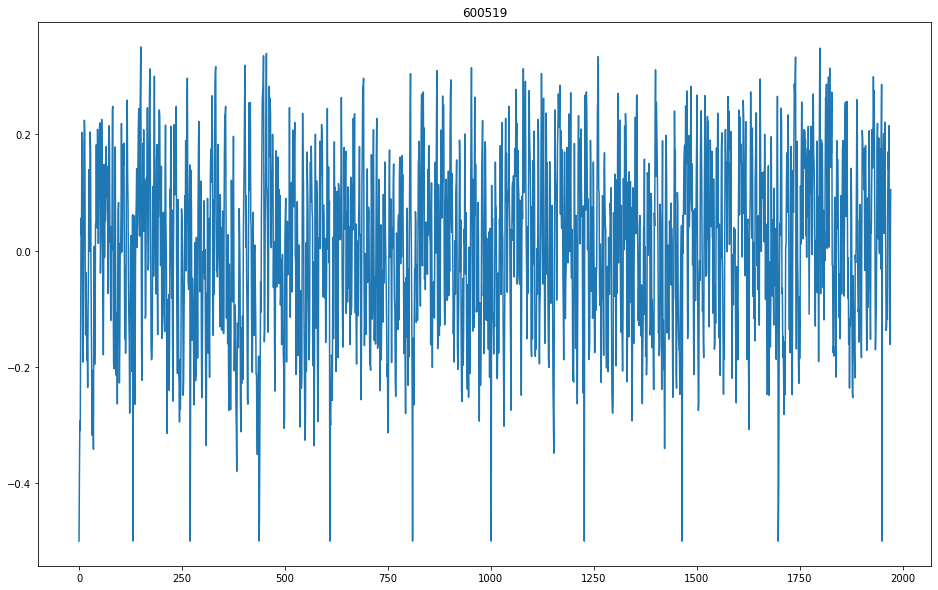

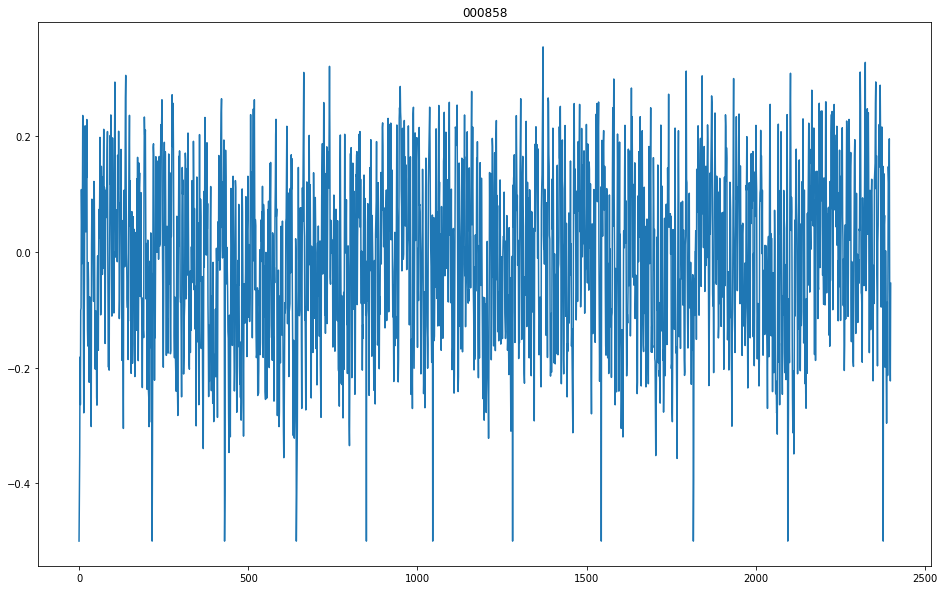

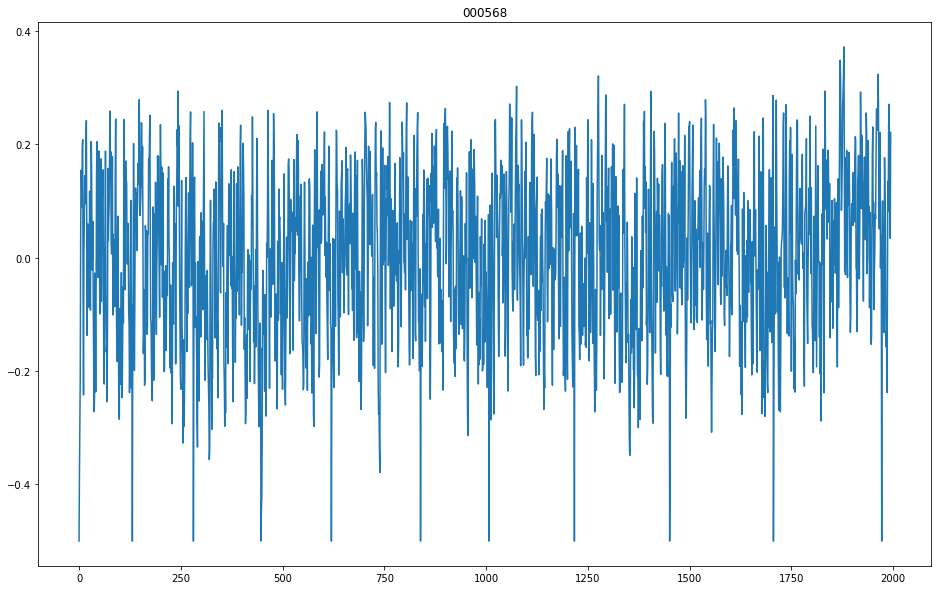

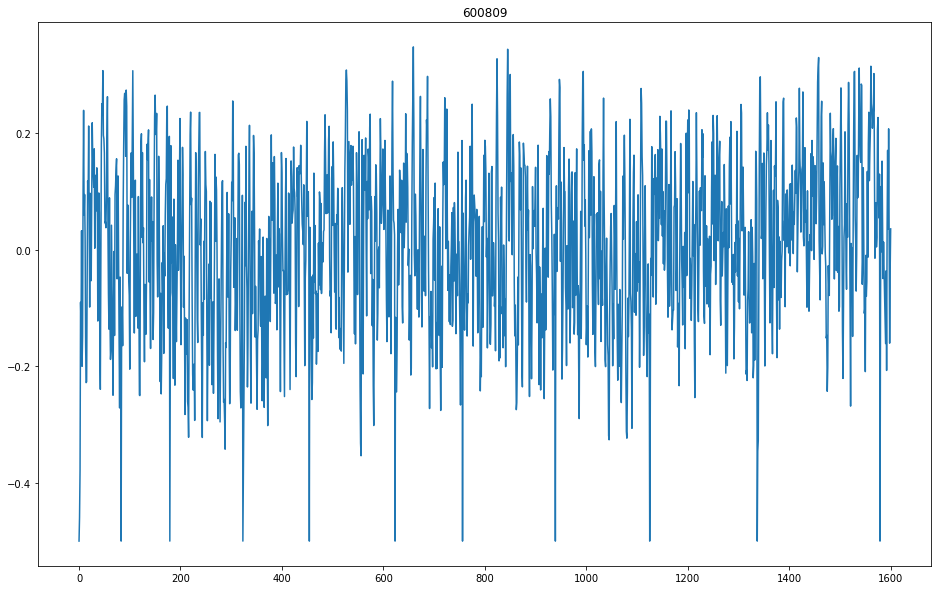

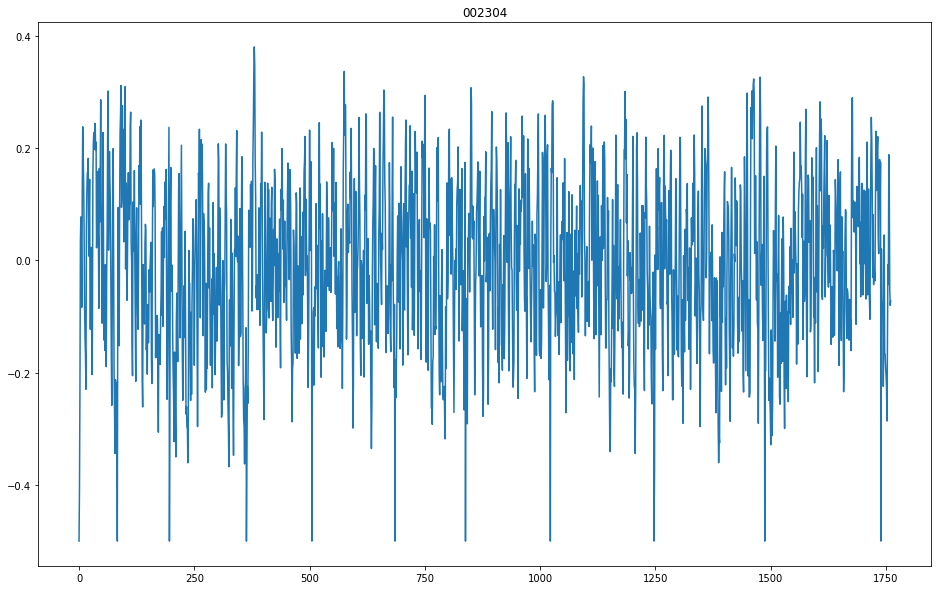

In [134]:
i = 0
for product in product_list:
    all_dates = sorted(os.listdir(DATA_PATH + product))
    all_signal = get_all_signal(np.array(all_dates), product, "range.pos."+str(period), period, HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

- there is no extreme values

## Grid Search + Backtesting

In [135]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.1, 0.3, 0.01)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [136]:
%%time
get_list_signal_stat("range.pos.4096", thre_mat_list, product_list, atr_filter_list,
                     split_str="2017", min_pnl=0.001, min_num=20, reverse=1)


# training
# 600519
# 6 5
# 000858
# 6 5
# 000568
# 6 5
# 600809
# 6 5
# 002304
# 6 5
# testing
# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 26min 32s



training
600519
6 5
000858
6 5
000568
6 5
600809
6 5
002304
6 5
testing
600519
000858
000568
600809
002304
CPU times: user 740 ms, sys: 722 ms, total: 1.46 s
Wall time: 9min 31s


In [137]:
signal_stat = get_list_signal_result("range.pos.4096", product_list, reverse=1, min_pnl=0.001, min_num=10)


# 600519 train sharpe  0.15418723525657693 test sharpe  -0.2611342801813223
# 000858 train sharpe  0.19087010921604822 test sharpe  -0.35080337034402326
# 000568 train sharpe  0.2902595582163596 test sharpe  -0.07938599641401735
# 600809 train sharpe  0.21266058451205505 test sharpe  0.25948026495424836
# 002304 train sharpe  0.3558920232283907 test sharpe  -0.23912812450433735


600519 train sharpe  0.15418723525657693 test sharpe  -0.26113428018132256
000858 train sharpe  0.19087010921604822 test sharpe  -0.3508033703440232
000568 train sharpe  0.2902595582163596 test sharpe  -0.0793859964140173
600809 train sharpe  0.21266058451205505 test sharpe  0.2594802649542483
002304 train sharpe  0.3558920232283907 test sharpe  -0.23912812450433735


# Factor ma.dif.10.period

## Define Factor

In [138]:


## double moving average
## long is perio,d short is round(period/10)
## we can use this idea to consturct many combinations
from collections import OrderedDict
class foctor_ma_diff_period(factor_template):
    factor_name = "ma.dif.10.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/10), adjust=True) - ewma(data["wpr"], period, adjust=True), data["wpr"]).values

In [139]:
x99_1 = foctor_ma_diff_period()

## Factor Generation

In [140]:
for product in product_list:
    create_signal_path(x99_1, product, SAVE_PATH)

./ckpt//tmp pkl/600519/ma.dif.10.4096
./ckpt//tmp pkl/000858/ma.dif.10.4096
./ckpt//tmp pkl/000568/ma.dif.10.4096
./ckpt//tmp pkl/600809/ma.dif.10.4096
./ckpt//tmp pkl/002304/ma.dif.10.4096


In [141]:
%%time
for product in product_list:
    print(product)
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, sorted(os.listdir(DATA_PATH + product))))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x99_1, product=product, HEAD_PATH=SAVE_PATH, n=8)
;

#600276
#000538
#600332
#600436
#600535
#Wall time: 1min 3s


600519
000858
000568
600809
002304
CPU times: user 307 ms, sys: 290 ms, total: 597 ms
Wall time: 29.1 s


''

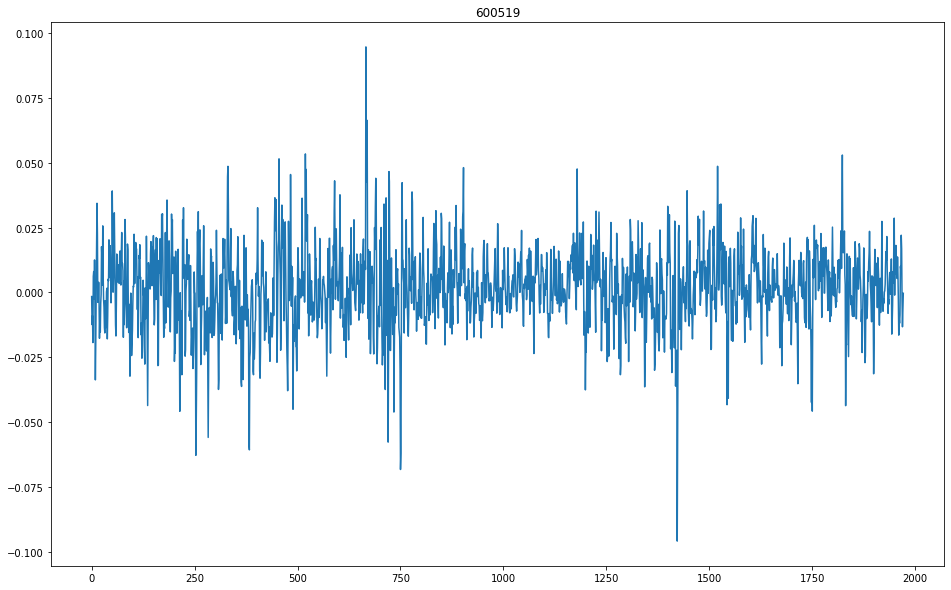

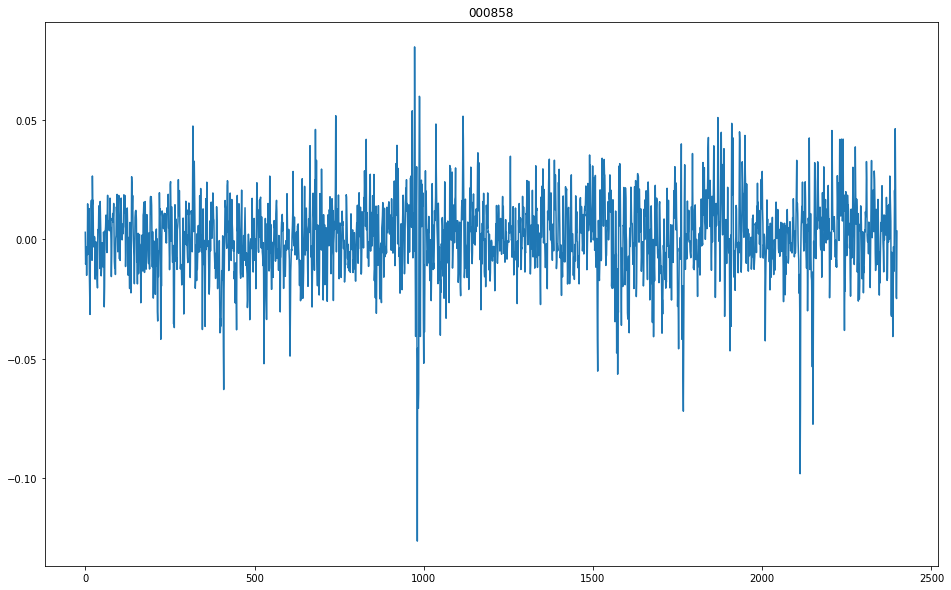

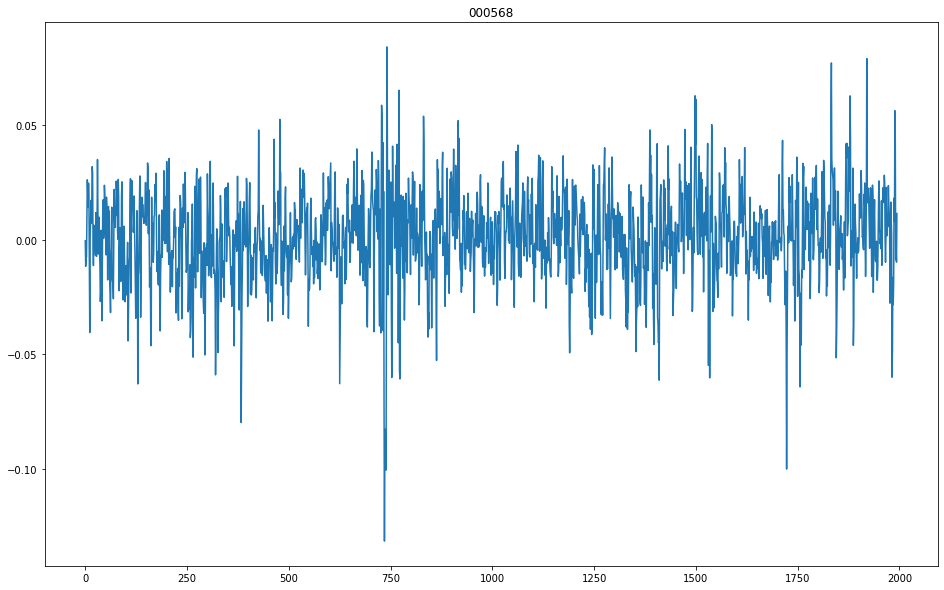

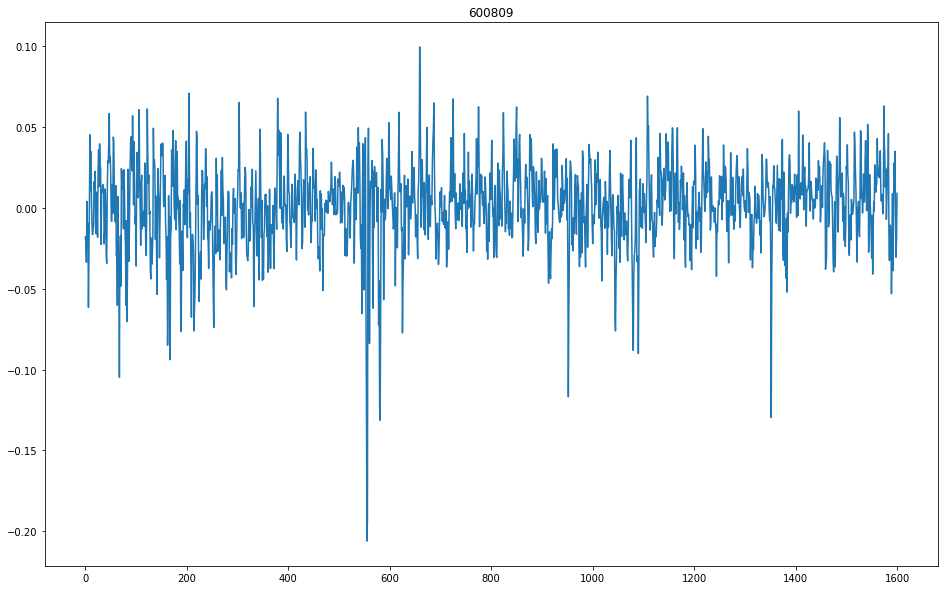

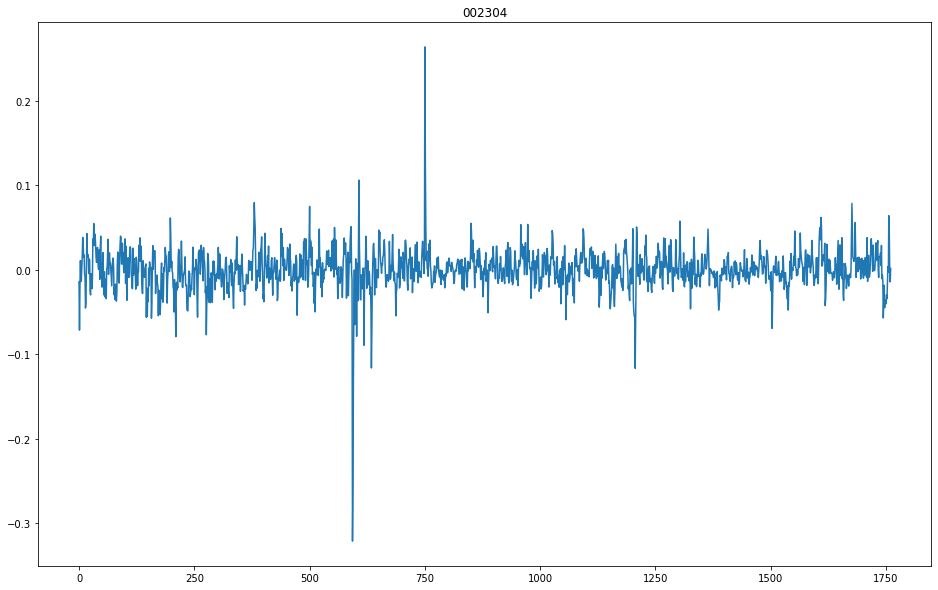

In [142]:
i = 0
period = 4096
for product in product_list:
    all_dates = sorted(os.listdir(DATA_PATH + product))
    all_signal = get_all_signal(np.array(all_dates), product, "ma.dif.10."+str(period), period,HEAD_PATH,SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

## Grid Search + Backtesting

In [143]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.02, 0.04, 0.001)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [144]:
%%time
get_list_signal_stat("ma.dif.10.4096", thre_mat_list, product_list, atr_filter_list,
                     split_str="2019", min_pnl=0.001, min_num=20, reverse=1)


###############
#training
#600276
#3 2
#000538
#3 2
#600332
#3 2
#600436
#3 2
#600535
#3 2
###############

#testing
#600276
#000538
#600332
#600436
#600535
#Wall time: 23min 28s


training
600519
8 3
000858
8 3
000568
8 3
600809
8 3
002304
8 3
testing
600519
000858
000568
600809
002304
CPU times: user 676 ms, sys: 631 ms, total: 1.31 s
Wall time: 10min 40s


In [145]:
signal_stat = get_list_signal_result("ma.dif.10.4096", product_list, reverse=1, min_pnl=0.001, min_num=20)

#600276 train sharpe  0.37928798886086584 test sharpe  -0.698544909312569
#000538 train sharpe  0.11698545000235559 test sharpe  0.034184388941648935
#600332 train sharpe  0.1102083396909225 test sharpe  -1.6562424145613983
#600436 train sharpe  0.20179849120719517 test sharpe  0.5988645028983702



600519 train sharpe  0.20102540121148613 test sharpe  0.5157665209875988
000858 train sharpe  0.3347776895494052 test sharpe  1.377791160012294
002304 train sharpe  0.26893423393535926 test sharpe  1.119350076551923


# Factor price.osci.period

## Define Factor

In [146]:
## similar to double ewma
## but divided by price range
## and short period is round(period/20)
## for exampl.e period/2, period/4, period/8...
## now period = 4096 =2^12, 
from collections import OrderedDict
class foctor_price_osci_period(factor_template):
    factor_name = "price.osci.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return zero_divide(ewma(data["wpr"], round(period/20), adjust=True)-ewma(data["wpr"], period, adjust=True), data["max."+str(period)]-data["min."+str(period)]).values

## Factor Generation

In [147]:
x113 = foctor_price_osci_period()
for product in product_list:
    create_signal_path(x113, product, SAVE_PATH)

./ckpt//tmp pkl/600519/price.osci.4096
./ckpt//tmp pkl/000858/price.osci.4096
./ckpt//tmp pkl/000568/price.osci.4096
./ckpt//tmp pkl/600809/price.osci.4096
./ckpt//tmp pkl/002304/price.osci.4096


In [148]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, sorted(os.listdir(DATA_PATH + product))))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x113, product=product, HEAD_PATH=SAVE_PATH, n=8)
;
# Wall time: 24min 33s

CPU times: user 311 ms, sys: 307 ms, total: 618 ms
Wall time: 31.5 s


''

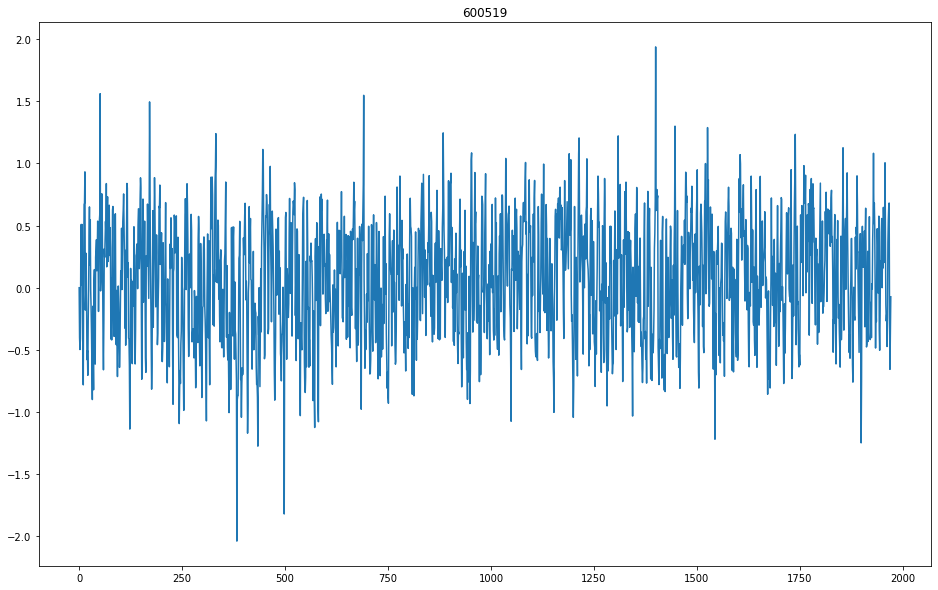

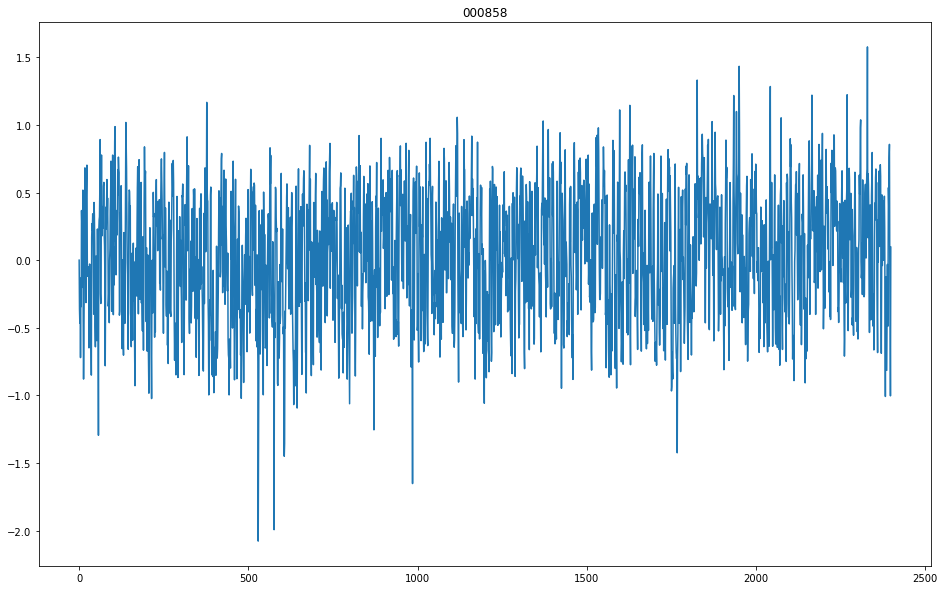

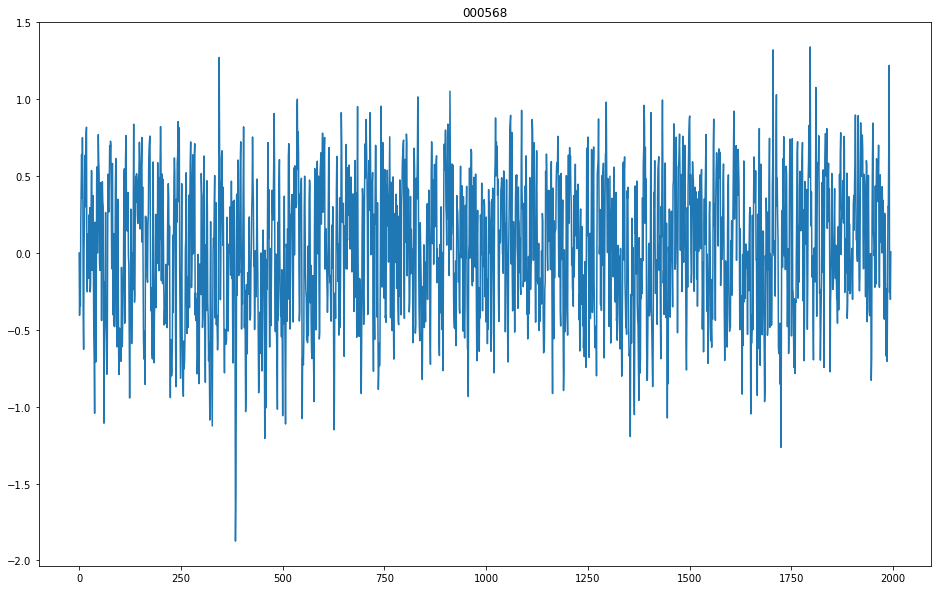

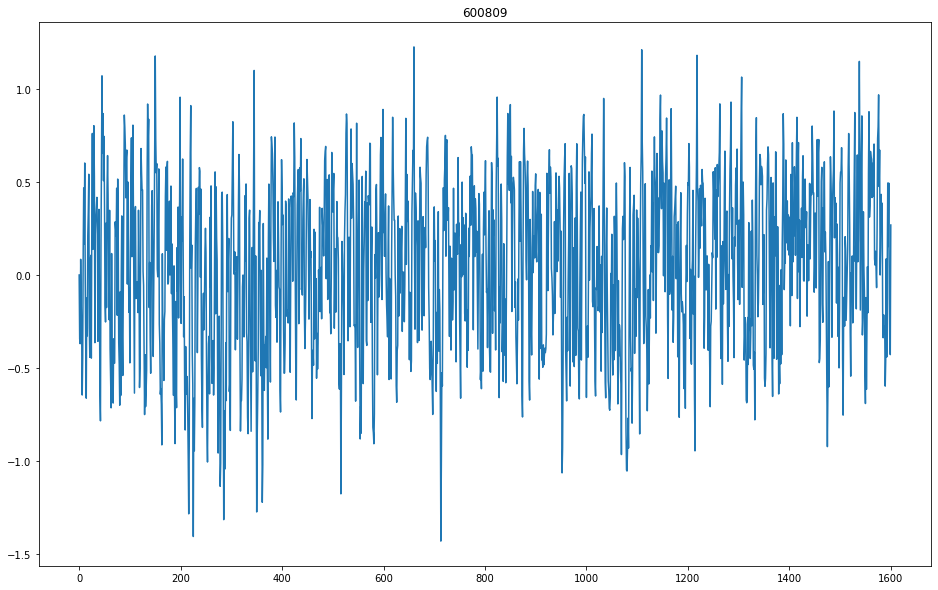

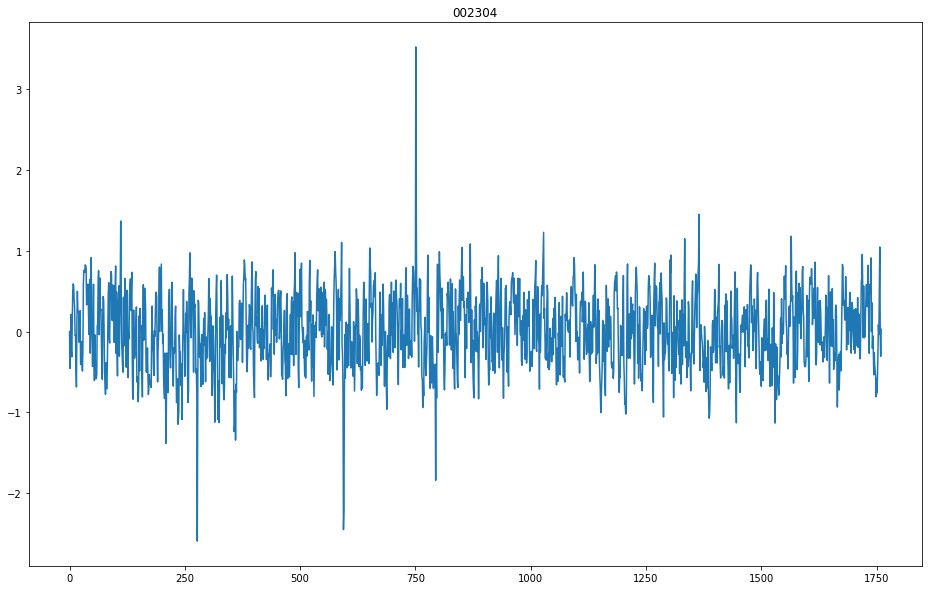

In [149]:
i = 0
period = 4096
for product in product_list:
    all_dates = sorted(os.listdir(DATA_PATH + product))
    all_signal = get_all_signal(np.array(all_dates), product, "price.osci."+str(period), period,HEAD_PATH,SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)

- before the last signal, let's do some analysis of skewness and kurtosis

## Grid Search + Backtesting

In [150]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.5, 1.5, 0.05)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [151]:
%%time
get_list_signal_stat("price.osci.4096", thre_mat_list, product_list, atr_filter_list,
                     split_str="2019", min_pnl=0.001, min_num=20, reverse=1)

# training
# 600519
# 8 3
# 000858
# 8 3
# 000568
# 8 3
# 600809
# 8 3
# 002304
# 8 3
# testing
# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 29min 46s



training
600519
8 3
000858
8 3
000568
8 3
600809
8 3
002304
8 3
testing
600519
000858
000568
600809
002304
CPU times: user 665 ms, sys: 629 ms, total: 1.29 s
Wall time: 10min 35s


In [152]:
%%time
signal_stat = get_list_signal_result("price.osci.4096", product_list, reverse=1, min_pnl=0.001, min_num=20)

# 600519 train sharpe  0.07824308840075246 test sharpe  0.8292563034513846
# 000858 train sharpe  0.06512549899274248 test sharpe  1.901574830694897
# 000568 train sharpe  0.10773062696217817 test sharpe  0.49820222193485925
# 600809 train sharpe  0.06563990072100595 test sharpe  1.743480630163399
# 002304 train sharpe  0.24876751322555035 test sharpe  0.726367813250811
# Wall time: 128 ms





600519 train sharpe  0.07824308840075246 test sharpe  0.8292563034513847
000858 train sharpe  0.06512549899274248 test sharpe  1.901574830694897
000568 train sharpe  0.10773062696217817 test sharpe  0.49820222193485925
600809 train sharpe  0.06563990072100595 test sharpe  1.7434806301633987
002304 train sharpe  0.24876751322555035 test sharpe  0.726367813250811
CPU times: user 42.6 ms, sys: 9.51 ms, total: 52.1 ms
Wall time: 52.1 ms


# Factor moment analysis - dbook, range.pos, ma.dif, price.osci, nr

In [153]:
from scipy.stats import kurtosis
from scipy.stats import skew
def get_signal_moment(signal, product_list, period):
    for product in product_list:
        all_dates = sorted(os.listdir(DATA_PATH + product))
        all_signal = get_all_signal(np.array(all_dates), product, signal+"."+str(period), period, SIGNAL_PATH=SAVE_PATH)
        print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))

In [154]:
%%time
get_signal_moment("dbook", product_list, 4096)

# 600519 kurtosis= 6.658171425657874  skew= -0.04555736870480391
# 000858 kurtosis= 4.427179115159534  skew= 0.36674901183706954
# 000568 kurtosis= 3.7419028474171987  skew= 0.1291984316558867
# 600809 kurtosis= 3.596362676448237  skew= 0.37267070151892173
# 002304 kurtosis= 4.036151152820614  skew= -0.16830306765366854
# Wall time: 5.24 s




600519 kurtosis= 6.658171425657874  skew= -0.04555736870480391
000858 kurtosis= 4.427179115159534  skew= 0.36674901183706954
000568 kurtosis= 3.7419028474171987  skew= 0.1291984316558867
600809 kurtosis= 3.596362676448237  skew= 0.37267070151892173
002304 kurtosis= 4.036151152820614  skew= -0.16830306765366854
CPU times: user 2.06 s, sys: 244 ms, total: 2.31 s
Wall time: 2.41 s


In [155]:
%%time
get_signal_moment("range.pos", product_list, 4096)

# 600519 kurtosis= 2.746625501167716  skew= -0.2400145390796257
# 000858 kurtosis= 2.696433018509884  skew= -0.19490742827691815
# 000568 kurtosis= 2.8838651535687565  skew= -0.3001316025432121
# 600809 kurtosis= 3.1049770712522493  skew= -0.32414121916404237
# 002304 kurtosis= 2.9285655496958816  skew= -0.1762657593969641
# Wall time: 5.13 s


600519 kurtosis= 2.746625501167716  skew= -0.2400145390796257
000858 kurtosis= 2.696433018509884  skew= -0.19490742827691815
000568 kurtosis= 2.8838651535687565  skew= -0.3001316025432121
600809 kurtosis= 3.1049770712522493  skew= -0.32414121916404237
002304 kurtosis= 2.9285655496958816  skew= -0.1762657593969641
CPU times: user 2.01 s, sys: 201 ms, total: 2.21 s
Wall time: 2.3 s


In [156]:
%%time
get_signal_moment("ma.dif.10", product_list, 4096)

# 600519 kurtosis= 5.8287016490646995  skew= -0.20069257170761337
# 000858 kurtosis= 6.99617193047326  skew= -0.532601443853718
# 000568 kurtosis= 5.946086232703944  skew= -0.5160613680504988
# 600809 kurtosis= 9.516859720973374  skew= -1.192207881174472
# 002304 kurtosis= 38.61852479469955  skew= -1.433436891790425
# Wall time: 5.23 s



600519 kurtosis= 5.8287016490646995  skew= -0.20069257170761337
000858 kurtosis= 6.99617193047326  skew= -0.532601443853718
000568 kurtosis= 5.946086232703944  skew= -0.5160613680504988
600809 kurtosis= 9.516859720973374  skew= -1.192207881174472
002304 kurtosis= 38.61852479469955  skew= -1.433436891790425
CPU times: user 2.02 s, sys: 210 ms, total: 2.23 s
Wall time: 2.32 s


In [157]:
%%time
get_signal_moment("price.osci", product_list, 4096)

# 600519 kurtosis= 2.7312756789033905  skew= -0.10209505107342766
# 000858 kurtosis= 2.643355083026254  skew= -0.1660756870567577
# 000568 kurtosis= 2.486701707999531  skew= -0.16170642126401047
# 600809 kurtosis= 2.474224227916128  skew= -0.2200374220786174
# 002304 kurtosis= 5.321822714255407  skew= -0.03010537497480942
# Wall time: 5.2 s




600519 kurtosis= 2.7312756789033905  skew= -0.10209505107342766
000858 kurtosis= 2.643355083026254  skew= -0.1660756870567577
000568 kurtosis= 2.486701707999531  skew= -0.16170642126401047
600809 kurtosis= 2.474224227916128  skew= -0.2200374220786174
002304 kurtosis= 5.321822714255407  skew= -0.03010537497480942
CPU times: user 2.02 s, sys: 178 ms, total: 2.2 s
Wall time: 2.23 s


In [158]:
%%time
get_signal_moment("nr", product_list, 4096)

# 600519 kurtosis= 6.265282469543895  skew= -0.39472477356148206
# 000858 kurtosis= 5.8786292012677945  skew= -0.2656649750715638
# 000568 kurtosis= 4.207184911391121  skew= -0.03063657720770369
# 600809 kurtosis= 4.222434638034899  skew= -0.2156331192788538
# 002304 kurtosis= 10.006397026471909  skew= 0.4947437302163155
# Wall time: 36 s




600519 kurtosis= 6.265282469543904  skew= -0.3947247735614838
000858 kurtosis= 5.878629201267793  skew= -0.26566497507156345
000568 kurtosis= 4.207184911391117  skew= -0.030636577207703904
600809 kurtosis= 4.2224346380348985  skew= -0.2156331192788541
002304 kurtosis= 10.006397026471916  skew= 0.4947437302163168
CPU times: user 2.06 s, sys: 210 ms, total: 2.27 s
Wall time: 2.36 s


# Factor kdj_k_period

## Define Factor

In [159]:
# 跟range.pos.period 类似？反映跟价格均值的背离关系
class foctor_kdj_k_period(factor_template):
    factor_name = "kdj.k.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5),
                   adjust=True).values
    

## Factor Generation

In [160]:
x11 = foctor_kdj_k_period()
for product in product_list:
    create_signal_path(x11, product, SAVE_PATH)

./ckpt//tmp pkl/600519/kdj.k.4096
./ckpt//tmp pkl/000858/kdj.k.4096
./ckpt//tmp pkl/000568/kdj.k.4096
./ckpt//tmp pkl/600809/kdj.k.4096
./ckpt//tmp pkl/002304/kdj.k.4096


In [161]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, sorted(os.listdir(DATA_PATH + product))))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x11, product=product, HEAD_PATH=SAVE_PATH, n=8)
;

#Wall time: 1min 24s

CPU times: user 314 ms, sys: 321 ms, total: 636 ms
Wall time: 30.7 s


''

600519 kurtosis= 1.8012773557149577  skew= -0.008263865856573526
000858 kurtosis= 1.8410947855299877  skew= 0.02956954357541264
000568 kurtosis= 1.8156519829264524  skew= -0.055564518213044534
600809 kurtosis= 1.83069362125161  skew= -0.10410428378983584
002304 kurtosis= 1.8476305126377346  skew= -0.002241570350124041


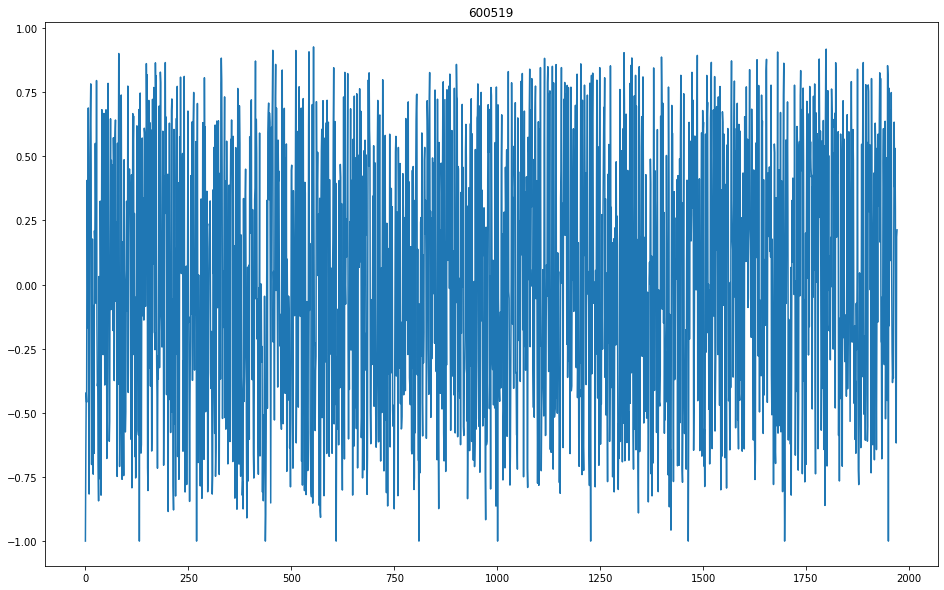

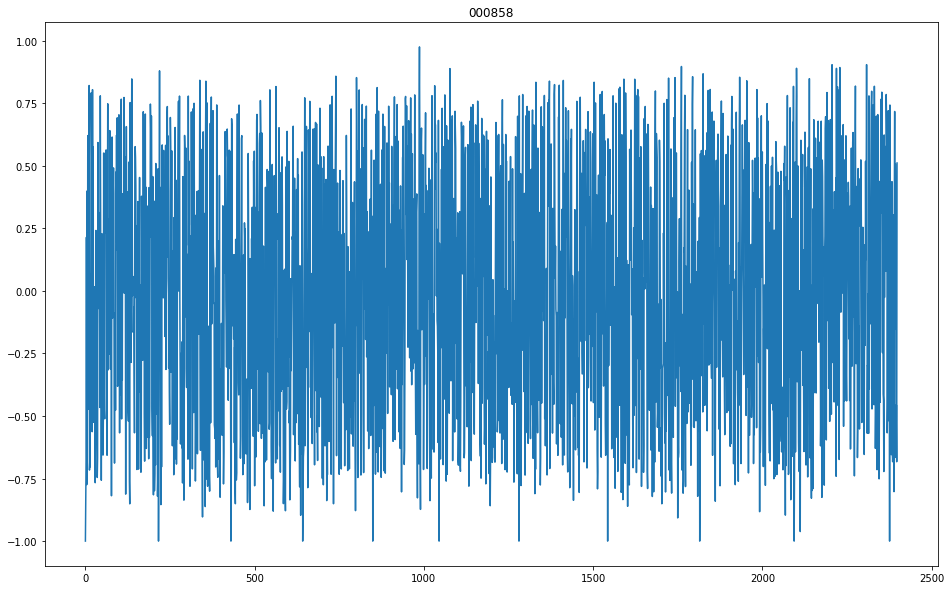

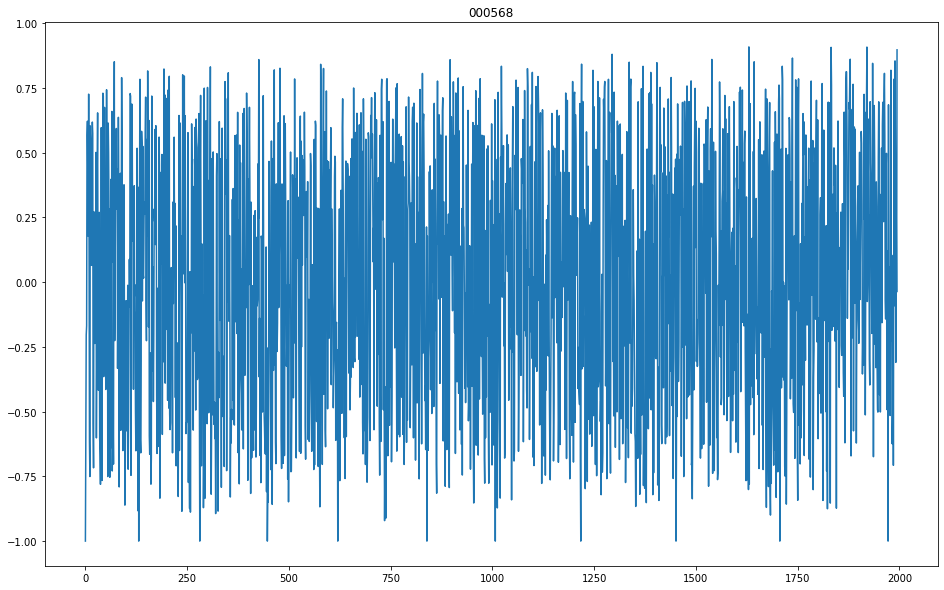

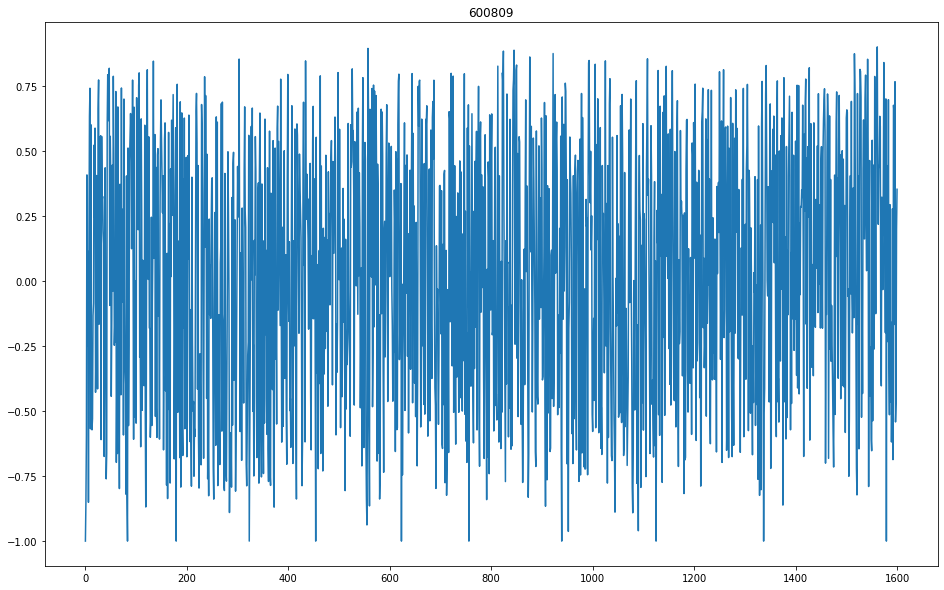

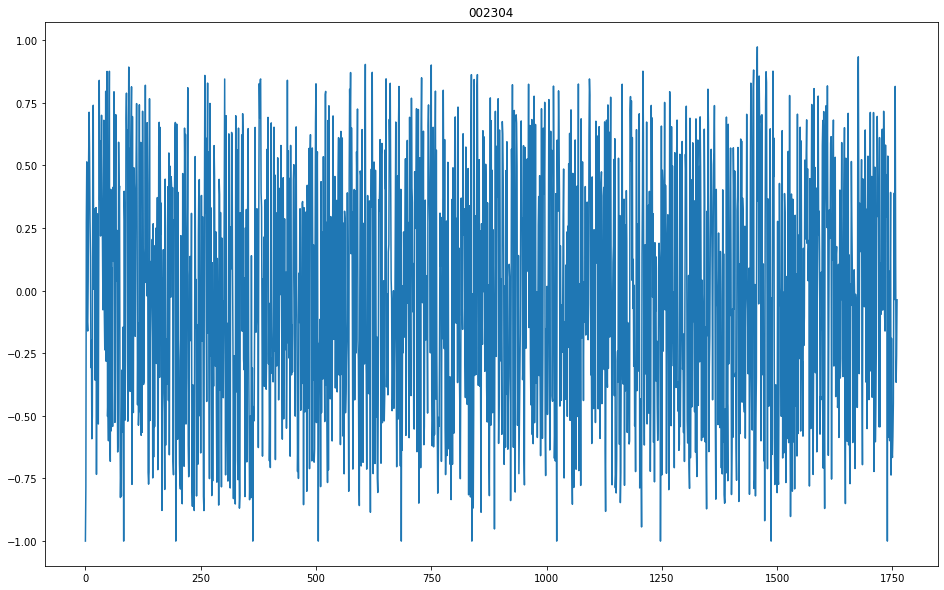

In [162]:
i = 0
period = 4096
for product in product_list:
    all_dates = sorted(os.listdir(DATA_PATH + product))
    all_signal = get_all_signal(np.array(all_dates), product, "kdj.k."+str(period), period,HEAD_PATH, SAVE_PATH)
    i = i+1
    plt.figure(i, figsize=(16, 10))
    plt.title(product)
    plt.plot(all_signal)
    print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal))


# 600519 kurtosis= 1.8012773557149577  skew= -0.008263865856573526
# 000858 kurtosis= 1.8410947855299877  skew= 0.02956954357541264
# 000568 kurtosis= 1.8156519829264524  skew= -0.055564518213044534
# 600809 kurtosis= 1.83069362125161  skew= -0.10410428378983584
# 002304 kurtosis= 1.8476305126377346  skew= -0.002241570350124041

- we know that standard normal distribution is 3, so 3.29 is a little bit higher but still close to normal distribution
- as we see above, range.pos.signal and dbook.signal are good signals, they have kurtosis of slightly above 3
- open.int.ret.signal and nr.signal are not good signals, and they have kurtosis above 8
- nr.vanish.signal is better than nr.signal, and it has kurtosis much lower
- so when we want to improve our signals, we can focus on how to decrease the kurtosis


- kurtosis is used to measure fatness and thiness of the shape of the density distribution
- financial has fat tails, which may lead to large kurtosis value
- so we can use vanish techniques to reduce it 

## Grid Search + Backtesting

In [163]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.5, 1, 0.025)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
np.shape(thre_mat)
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat

In [164]:
%%time
get_list_signal_stat("kdj.k.4096", thre_mat_list, product_list, atr_filter_list,
                     split_str="2017", min_pnl=0.001, min_num=20, reverse=1)


# training
# 600519
# 6 5
# 000858
# 6 5
# 000568
# 6 5
# 600809
# 6 5
# 002304
# 6 5
# testing
# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 26min 43s





training
600519
6 5
000858
6 5
000568
6 5
600809
6 5
002304
6 5
testing
600519
000858
000568
600809
002304
CPU times: user 676 ms, sys: 674 ms, total: 1.35 s
Wall time: 9min 26s


In [165]:
%%time
signal_stat = get_list_signal_result("kdj.k.4096", product_list, reverse=1, min_pnl=0.001, min_num=20)


# 000568 train sharpe  0.2895439829306344 test sharpe  -0.014095720748617247
# 600809 train sharpe  0.31765341060351987 test sharpe  -0.36474172086741075
# 002304 train sharpe  0.46953937418150005 test sharpe  -0.4395302667825336
# Wall time: 133 ms




000568 train sharpe  0.2895439829306344 test sharpe  -0.014095720748617414
600809 train sharpe  0.31765341060351987 test sharpe  -0.3647417208674108
002304 train sharpe  0.46953937418150005 test sharpe  -0.43953026678253365
CPU times: user 52.1 ms, sys: 10.7 ms, total: 62.8 ms
Wall time: 61.4 ms


In [166]:
%%time
get_list_signal_stat("kdj.k.4096", thre_mat_list, product_list, atr_filter_list,
                     split_str="2017", min_pnl=0.001, min_num=20, reverse=-1)


# training
# 600519
# 6 5
# 000858
# 6 5
# 000568
# 6 5
# 600809
# 6 5
# 002304
# 6 5
# testing
# 600519
# 000858
# 000568
# 600809
# 002304
# Wall time: 26min 43s


training
600519
6 5
000858
6 5
000568
6 5
600809
6 5
002304
6 5
testing
600519
000858
000568
600809
002304
CPU times: user 673 ms, sys: 690 ms, total: 1.36 s
Wall time: 9min 22s


# Factor kdj_j

## Define Factor

In [167]:
class foctor_kdj_j_period(factor_template):
    factor_name = "kdj.j.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(12,13)))
    ])
    
    def formula(self, data, period):
        return ewma(ewma((zero_divide(data["wpr"]-data["min."+str(period)], data["max."+str(period)]-data["min."+str(period)])-0.5)*2, round(period/5),
                        adjust=True), round(period/5), adjust=True).values
    


## Factor Generation

In [168]:
x12 = foctor_kdj_j_period()
for product in product_list:
    create_signal_path(x12, product, SAVE_PATH)

./ckpt//tmp pkl/600519/kdj.j.4096
./ckpt//tmp pkl/000858/kdj.j.4096
./ckpt//tmp pkl/000568/kdj.j.4096
./ckpt//tmp pkl/600809/kdj.j.4096
./ckpt//tmp pkl/002304/kdj.j.4096


In [169]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, sorted(os.listdir(DATA_PATH + product))))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x12, product=product, HEAD_PATH=SAVE_PATH, n=8)
;
# Wall time: 1min 24s

CPU times: user 302 ms, sys: 312 ms, total: 613 ms
Wall time: 31.9 s


''

### momentum skew kurtosis assessemtn 

600519 kurtosis= 1.9486256935129938  skew= -0.03514525387390287
000858 kurtosis= 1.998767130353502  skew= -0.002255255842007843
000568 kurtosis= 1.982324318134811  skew= -0.0695226736683022
600809 kurtosis= 2.0562004422252507  skew= -0.1381010301265319
002304 kurtosis= 2.0061823268546655  skew= -0.021910524169518057
CPU times: user 2.09 s, sys: 244 ms, total: 2.33 s
Wall time: 2.45 s


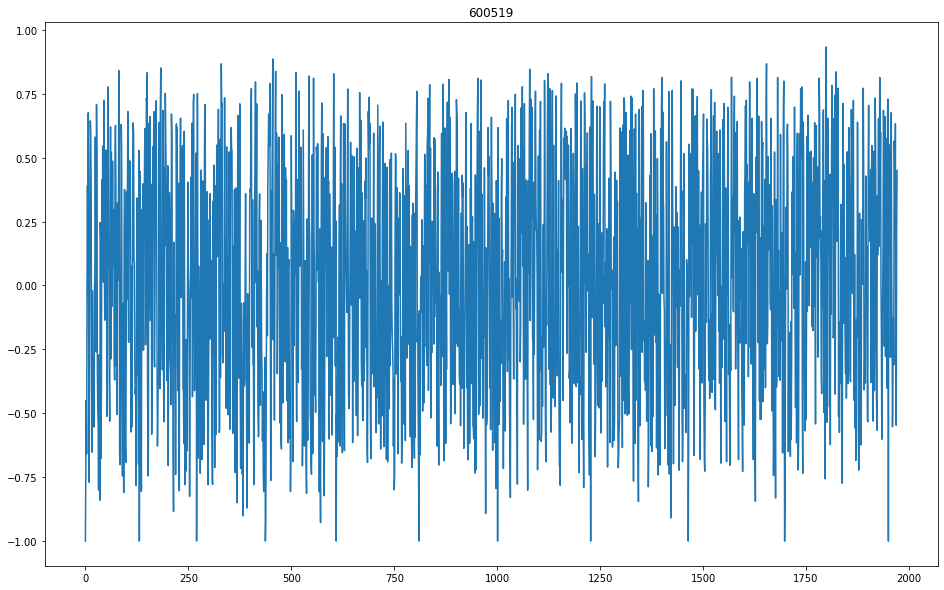

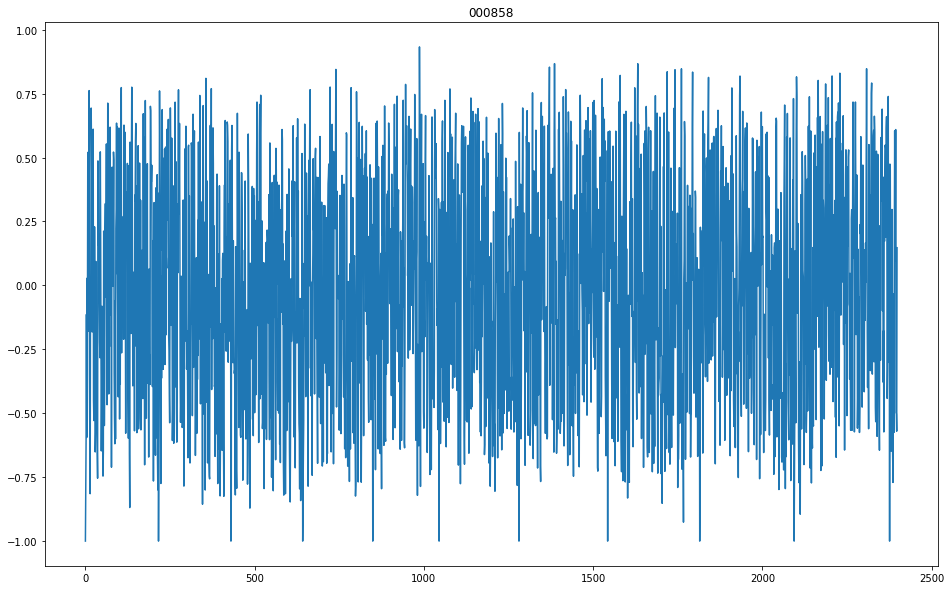

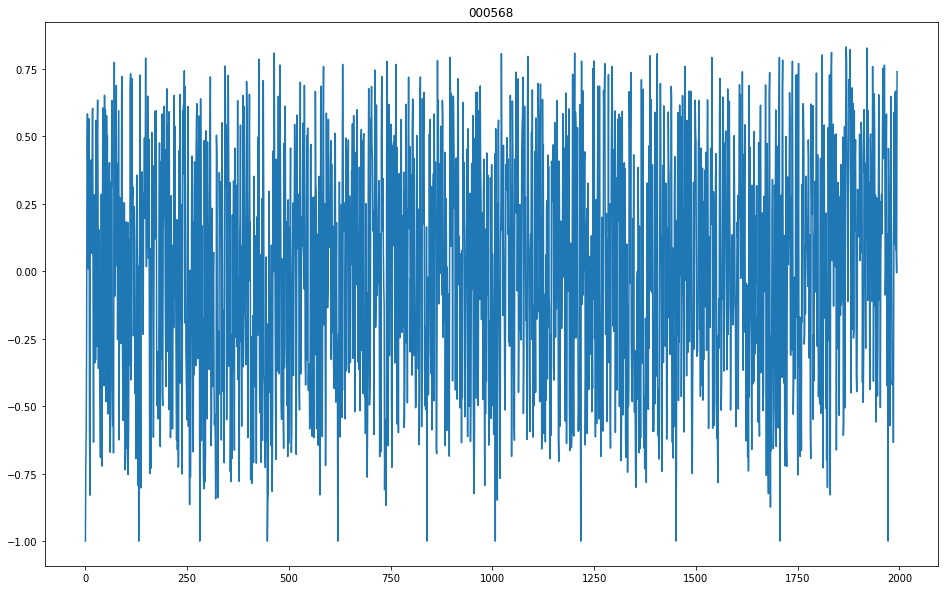

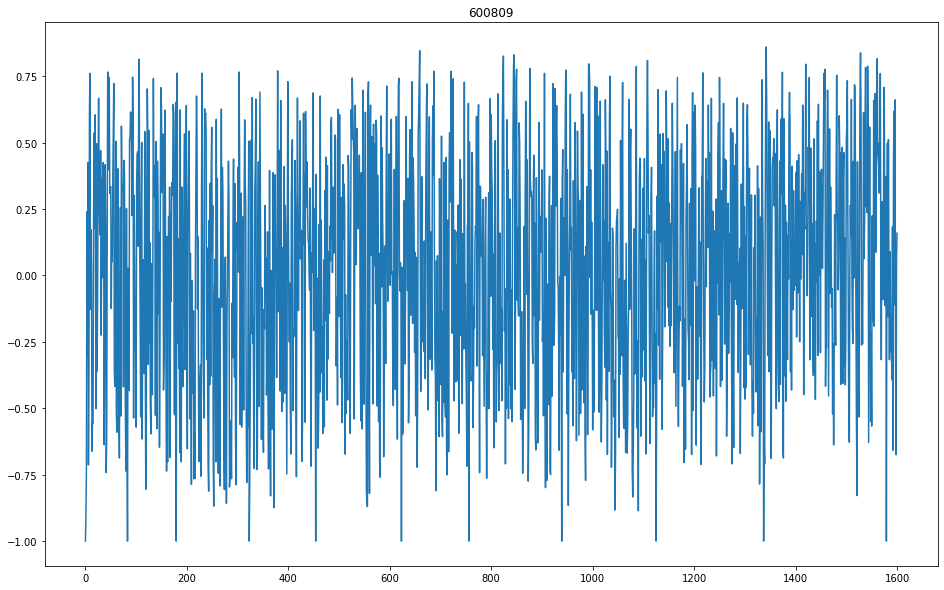

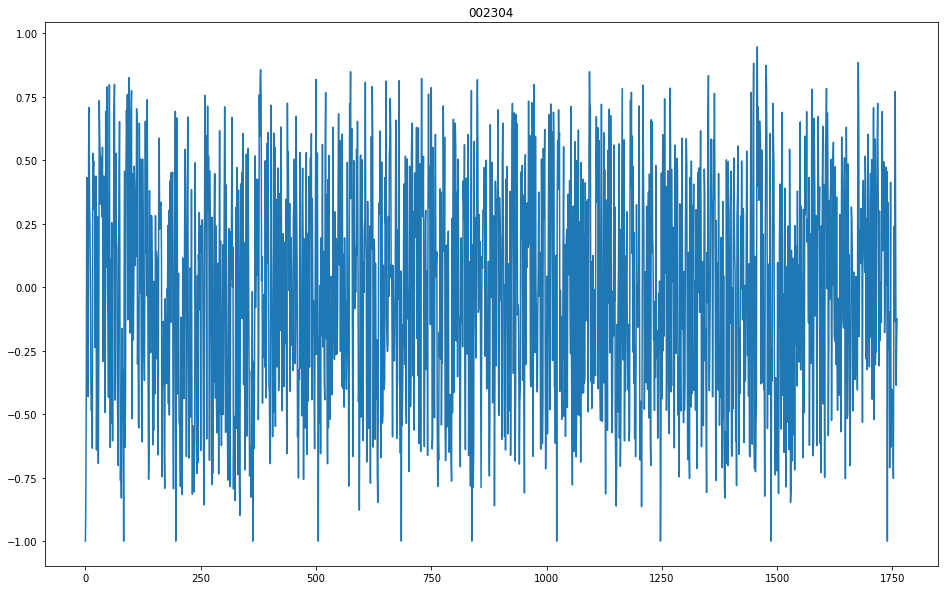

In [170]:
%%time
i = 0
period = 4096
for product in product_list:
    all_dates = sorted(os.listdir(DATA_PATH + product))
    all_signal = get_all_signal(np.array(all_dates), product, "kdj.j."+str(period), period,HEAD_PATH,SAVE_PATH)
    i = i+1;
    plt.figure(i, figsize=(16, 10));
    plt.title(product);
    plt.plot(all_signal);
    print(product, "kurtosis=", kurtosis(all_signal, fisher=False), " skew=", skew(all_signal));
    

# 600519 kurtosis= 1.9486256935129938  skew= -0.03514525387390287
# 000858 kurtosis= 1.998767130353502  skew= -0.002255255842007843
# 000568 kurtosis= 1.982324318134811  skew= -0.0695226736683022
# 600809 kurtosis= 2.0562004422252507  skew= -0.1381010301265319
# 002304 kurtosis= 2.0061823268546655  skew= -0.021910524169518057
# Wall time: 5.27 s






## Grid Search + Backtesting

In [171]:
from collections import OrderedDict
import itertools
open_list = np.arange(0.5, 1, 0.025)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
bitmex_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
thre_mat_list = dict([])
for product in product_list:
    thre_mat_list[product] = thre_mat



In [172]:
%%time
get_list_signal_stat("kdj.j.4096", thre_mat_list, product_list, atr_filter_list,
                     split_str="2017", min_pnl=0.001, min_num=20, reverse=1)


#training
#600276
#3 2
#000538
#3 2
#600332
#3 2
#600436
#3 2
#600535
#3 2
#testing
#600276
#000538
#600332
#600436
#600535
#Wall time: 22min 21s



training
600519
6 5
000858
6 5
000568
6 5
600809
6 5
002304
6 5
testing
600519
000858
000568
600809
002304
CPU times: user 659 ms, sys: 649 ms, total: 1.31 s
Wall time: 9min 26s


In [173]:
signal_stat = get_list_signal_result("kdj.j.4096", product_list,min_pnl=0.001, min_num=20)

# 000858 train sharpe  0.12126400011122697 test sharpe  0.10266688849607897
# 000568 train sharpe  0.3018686953322465 test sharpe  -0.17120616277228473
# 600809 train sharpe  0.15669378294183842 test sharpe  -0.21813494462706265
# 002304 train sharpe  0.45039101396070397 test sharpe  -0.21531536892148365



000858 train sharpe  0.12126400011122697 test sharpe  0.10266688849607897
000568 train sharpe  0.3018686953322465 test sharpe  -0.17120616277228481
600809 train sharpe  0.15669378294183842 test sharpe  -0.21813494462706276
002304 train sharpe  0.45039101396070397 test sharpe  -0.21531536892148379
